Script de carga datos MySQL en cluster con Mongo

In [1]:
!pip install mysql-connector==2.1.7
!pip install pandas
!pip install sqlalchemy
#requiere instalación adicional, consultar https://github.com/PyMySQL/mysqlclient
!pip install mysqlclient
!pip install numpy
!pip install pymysql

In [2]:
import mysql.connector
from mysql.connector import Error
import pandas as pd
import numpy as np
import sqlalchemy
import time
import matplotlib.pyplot as plt

from mysql.connector.cursor import MySQLCursor

In [3]:
#Los resultados de medidas de tiempo en carga por dominios se almacenan en estos objetos.
#Se itera durante 100 iteraciones para sacar medias
CustomerProfileDomainSchema_ds = []
PositionKeepingDomainSchema_ds = []
CurrentAccountDomainSchema_ds = []

#repeticiones
repeats = 1000

In [4]:
#Borrado de la tabla antes de carga 
def prepare_table_for_load(entity):
    alter_table_q = 'ALTER TABLE {} AUTO_INCREMENT=0'.format(entity)
    delete_table_q = 'DELETE FROM {}'.format(entity)
    cursor.execute(alter_table_q)
    cursor.execute(delete_table_q)

In [5]:
#Deshabilitar y habilitar Foreing key (cargas masivas)
def set_foreing_key_mysql_value(value):
    cursor.execute('SET foreign_key_checks = {}'.format(value))

# CustomerProfileDomainSchema

In [7]:
CustomerProfile_csv_file = "../MockData/CustomerProfile.csv"
Address_csv_file = "../MockData/Address.csv"
Country_csv_file = "../MockData/Country.csv"

In [8]:
Country_df = pd.read_csv(Country_csv_file, header=[0])
Country_df['Code'] = Country_df["Code"]
Country_df

,CountryId,ShortName,Description,Code,Unnamed: 4
0,1,Spain,Omnis dolore id dicta consequatur sit omnis. E...,IND,NaN
1,2,USA,Id dolorem a soluta harum iusto qui repellat. ...,GBP,NaN
2,3,Greatbrit,Aut sapiente dicta illo consectetur nulla labo...,SPA,NaN


In [9]:
#TRATAMIENTO ENTIDAD ADDRESS
Address_df = pd.read_csv(Address_csv_file, header=[0])

del(Address_df['Unnamed: 9'])
Address_df['AddressType'] = Address_df["AddressType"].str[:3]
CountrySubDivisionList=['abc','def','hig']
Address_df['CountrySubDivision'] = np.resize(CountrySubDivisionList,len(Address_df))

Address_df['PostCode'] = Address_df['PostCode'].astype('string')
Address_df['CountrySubDivision'] = Address_df['CountrySubDivision'].astype('string')

#Generamos una función mas de 1M de registros basados en registros anteriores
def generate_new_values_by_samples(df,rango):
    for x in range(rango):
        df = df.append(df.sample(frac=0.50,replace = False))
    return df


Address_df = generate_new_values_by_samples(Address_df,9)

print(len(Address_df))
Address_df.sample(1)

12611


,PartyId,AddressType,AddressLine,StreetName,BuildingNumber,PostCode,TownName,CountrySubDivision,CountryId
163,5307,Lak,07927 Jayne Rapids Apt. 230,McLaughlin Parks,203,50404-3530,Watsicaville,def,3


In [10]:
#TRATAMIENTO ENTIDAD CUSTOMER PROFILE

CustomerProfile_df = pd.read_csv(CustomerProfile_csv_file, header=[0])

#Indexado PartyId para mejor legibilidad
CustomerProfile_df['PartyId'].reset_index()
CustomerProfile_df['PartyId'] = CustomerProfile_df.index
CustomerProfile_df[CustomerProfile_df.columns[pd.Series(CustomerProfile_df.columns).str.startswith('Unnamed:')]]

#Limpieza de datos. Eliminamos el apostrofe del campo AccountRole y PartyType
CustomerProfile_df['AccountRole'] = CustomerProfile_df['AccountRole'].str.replace("'",'')
CustomerProfile_df['PartyType'] = CustomerProfile_df['PartyType'].str.replace("'",'')

#Phone y PArtyData debe ser truncado (error generacion FillDB)
CustomerProfile_df['Phone'] = CustomerProfile_df["Phone"].str[:10]
CustomerProfile_df['PartyType'] = CustomerProfile_df["PartyType"].str[:2]
BeneficialOwnerShipValues=[1,2,3,4,5,6,7]
CustomerProfile_df['BeneficialOwnership'] = np.resize(BeneficialOwnerShipValues,len(CustomerProfile_df))

print(len(CustomerProfile_df))
CustomerProfile_df.sample(1)

10000


,PartyId,PartyNumber,PartyType,Name,FullLegalName,LegalStructure,BeneficialOwnership,AccountRole,EmailAddress,Phone,Unnamed: 10
8346,8346,599110.0,so,Adaline,Marlene Schaden,Dr.,3,US.OBIE.Principal,vaughn.nicolas@example.net,645-293-91,NaN


In [34]:
conn = mysql.connector.connect(host='localhost',
                                    port=6446,
                                    database='CustomerProfileDomainSchema',
                                    user='root',                                       
                                    password='mysql')
if conn.is_connected():
        conn.autocommit = False #Apenas se observa diferencia de rendimiento
        print('Connected to MySQL database')
    
cursor = conn.cursor()  
    
def connection_open():
   
    #InnoDB Cluster
    conn = mysql.connector.connect(host='localhost',
                                    port=6446,
                                    database='CustomerProfileDomainSchema',
                                    user='root',                                       
                                    password='mysql')


    if conn.is_connected():
        conn.autocommit = False #Apenas se observa diferencia de rendimiento
        print('Connected to MySQL database')
    
    cursor = conn.cursor()  

Connected to MySQL database


## ETL entidad country

In [22]:
Country_ETL_times = []

In [23]:
Country_Insert_query = 'INSERT INTO Country(ShortName,Description,Code) VALUES(%s, %s, %s)'

def load_country():
    time_inicial = time.time()
    for i,row in Country_df.iterrows():
        cursor.execute(Country_Insert_query,(row[1],row[2],row[3]))          
    time_final = time.time()
    Country_ETL_times.append(time_final - time_inicial)
    conn.commit() 
    return Country_ETL_times 

In [24]:
connection_open()
prepare_table_for_load('CustomerProfileDomainSchema.Country')
load_country()

Connected to MySQL database


In [25]:
print("MAX:" , max(Country_ETL_times), 'seg')
print("MIN:" , min(Country_ETL_times), 'seg')
print("AVG:" , np.average(Country_ETL_times), 'seg')

MAX: 0.0027780532836914062 seg
MIN: 0.0027780532836914062 seg
AVG: 0.0027780532836914062 seg


## ETL entidad CustomerProfile

In [26]:
CoustomerProfile_ETL_times = []

In [28]:
#Preparamos un dataset solo con los values a cargar en la insercción
CustomerProfile_sql_df = CustomerProfile_df[['PartyId','PartyNumber', 'PartyType', 'Name', 'FullLegalName','LegalStructure', 'BeneficialOwnership', 'AccountRole', 'EmailAddress','Phone']]
CustomerProfile_df.reset_index(drop=True, inplace=True)

In [45]:
#Leemos el dataset y cargamos la entidad
def load_customer_profile():
    time_acum = 0    
    trx = True
    jump = 2000
    for i,row in CustomerProfile_df.iterrows():
        if(trx):
            #conn.start_transaction()
            #print('Inicio transaccion en iteracion:', i)            
            trx = False
        if(i > jump):
            conn.commit()
            jump = jump + 10000
            trx = True            
        time_inicial = time.time()        
        cursor.execute('INSERT INTO CustomerProfile(PartyNumber,PartyType,Name,FullLegalName,LegalStructure,BeneficialOwnership,AccountRole,EmailAddress,Phone) VALUES("%s", "%s", "%s", "%s", "%s", "%s", "%s", "%s", "%s")',(row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9]))
        time_final = time.time()
        time_acum = time_acum + (time_final - time_inicial)
    conn.commit()    
    CoustomerProfile_ETL_times = time_acum
    return CoustomerProfile_ETL_times

In [50]:
connection_open()
prepare_table_for_load('CustomerProfileDomainSchema.CustomerProfile')
for i in range(0,100):  
    CoustomerProfile_ETL_times.append(load_customer_profile())
conn.commit()

Connected to MySQL database
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execute Commit: 2001
Execut

In [48]:
print("TOTAL TIME:" , np.sum(CoustomerProfile_ETL_times), 'seg')
print("MAX:" , max(CoustomerProfile_ETL_times), 'seg')
print("MIN:" , min(CoustomerProfile_ETL_times), 'seg')
print("AVG:" , np.average(CoustomerProfile_ETL_times), 'seg')

TOTAL TIME: 132.85731029510498 seg
MAX: 5.269923686981201 seg
MIN: 3.538896322250366 seg
AVG: 4.151790946722031 seg


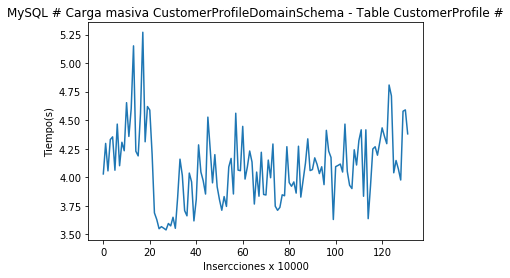

In [51]:
gfg = pd.Series(CoustomerProfile_ETL_times)  
gfg.plot()
plt.title("MySQL # Carga masiva CustomerProfileDomainSchema - Table CustomerProfile #")
plt.xlabel("Insercciones x 10000")
plt.ylabel("Tiempo(s)")
plt.show()

# ETL entidad Address

In [540]:
Address_ETL_times = []

In [541]:
Address_df.columns

Index(['PartyId', 'AddressType', 'AddressLine', 'StreetName', 'BuildingNumber',
       'PostCode', 'TownName', 'CountrySubDivision', 'CountryId'],
      dtype='object')

In [542]:
Address_sql_df = Address_df[['PartyId', 'AddressType', 'AddressLine', 'StreetName', 'BuildingNumber',       'PostCode', 'TownName', 'CountrySubDivision', 'CountryId']]
Address_sql_df.reset_index(drop=True, inplace=True)
Address_sql_df.to_records()
Address_sql_df.columns

Index(['PartyId', 'AddressType', 'AddressLine', 'StreetName', 'BuildingNumber',
       'PostCode', 'TownName', 'CountrySubDivision', 'CountryId'],
      dtype='object')

In [543]:
#Leemos el dataset y cargamos la entidad  
def load_address():    
    data_time_Address = 0
    for values in Address_sql_df.to_records():
    #for i,row in Address_df.to_iterrows():
        insert_query = "INSERT INTO Address (PartyId, AddressType, AddressLine, StreetName, BuildingNumber, PostCode, TownName, CountrySubDivision, CountryId) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)"    
        #cursor.execute(insert_query,(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8]),multi=True)
        time_inicial = time.time()
        cursor.execute(insert_query,values,multi=True)
        time_final = time.time()
        data_time_Address = data_time_Address + (time_final - time_inicial)
    return data_time_Address

In [544]:
for i in range(0,repeats):
    prepare_table_for_load('CustomerProfileDomainSchema.Address')
    Address_ETL_times.append(load_address())
conn.commit()    

In [545]:
print("ROWS INSERTED:", len(Address_ETL_times) * len(Address_df))
print("TOTAL TIME:" , np.sum(CoustomerProfile_ETL_times), 'seg')
print("MAX:" , max(Address_ETL_times), 'seg')
print("MIN:" , min(Address_ETL_times), 'seg')
print("AVG:" , np.average(Address_ETL_times), 'seg')

ROWS INSERTED: 12611000
TOTAL TIME: 40.57196259498596 seg
MAX: 0.09462118148803711 seg
MIN: 0.046700477600097656 seg
AVG: 0.05000570583343506 seg


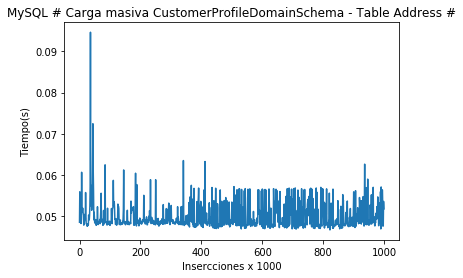

In [546]:
gfg = pd.Series(Address_ETL_times)  
gfg.plot()
plt.title("MySQL # Carga masiva CustomerProfileDomainSchema - Table Address #")
plt.xlabel("Insercciones x 10000")
plt.ylabel("Tiempo(s)")
plt.show()

In [580]:
set_foreing_key_mysql_value(0)
print("Desabilitadas las comprobaciones de foreing key")

Desabilitadas las comprobaciones de foreing key


In [581]:
#Resultados finales de CurrentDomainSchema
Total_CurrentDomainSchema = []

for i in range(0,repeats):
    prepare_table_for_load('CustomerProfileDomainSchema.Address')
    prepare_table_for_load('CustomerProfileDomainSchema.CustomerProfile')
    load_customer_profile()+ load_address()
    Total_CurrentDomainSchema.append(load_address())

conn.commit() 

In [584]:
set_foreing_key_mysql_value(1)
print("Habilitadas las comprobaciones de foreing key")

Habilitadas las comprobaciones de foreing key


In [585]:
print("ROWS INSERTED:", len(Total_CurrentDomainSchema) * (len(Address_df) + len(CustomerProfile_df)))
print("TOTAL TIME:" , np.sum(Total_CurrentDomainSchema), 'seg')
print("MAX:" , max(Total_CurrentDomainSchema), 'seg')
print("MIN:" , min(Total_CurrentDomainSchema), 'seg')
print("AVG:" , np.average(Total_CurrentDomainSchema), 'seg')

ROWS INSERTED: 22611000
TOTAL TIME: 47.42606711387634 seg
MAX: 0.05254864692687988 seg
MIN: 0.04536914825439453 seg
AVG: 0.04742606711387634 seg


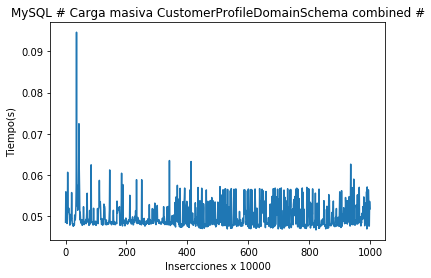

In [586]:
gfg = pd.Series(Address_ETL_times)  
gfg.plot()
plt.title("MySQL # Carga masiva CustomerProfileDomainSchema combined #")
plt.xlabel("Insercciones x 10000")
plt.ylabel("Tiempo(s)")
plt.show()

# CurrentAccountDomainSchema Load

In [508]:
CurrentAccount_csv_file = "../MockData/CurrentAccount.csv"
AccountInfo_csv_file = "../MockData/AccountInfo.csv"

In [515]:
CurrentAccount_df = pd.read_csv(CurrentAccount_csv_file, header=[0])
del(CurrentAccount_df['Unnamed: 8'])
CurrentAccount_df['Status'] = CurrentAccount_df['Status'].str.replace("'",'')
CurrentAccount_df['AccountType'] = CurrentAccount_df['AccountType'].str.replace("'",'')
CurrentAccount_df['AccountSubType'] = CurrentAccount_df['AccountSubType'].str.replace("'",'')
CurrentAccount_df.sample(1)

,AccountId,PartyId,Status,StatusUpdateDateTime,AccountType,NickName,OpeningDate,AccountSubType
8048,8049,8049,Enabled,1975-10-25 14:52:08.00,Particular,grow frictionless partnerships,1977-08-24 04:21:53.00,POI


In [517]:
cursor.execute('ALTER TABLE CurrentAccountDomainSchema.CurrentAccount AUTO_INCREMENT=0')
cursor.execute('DELETE FROM CurrentAccountDomainSchema.CurrentAccount')

In [519]:
for i,row in CurrentAccount_df.iterrows():
    insert_query = "INSERT INTO CurrentAccountDomainSchema.CurrentAccount (AccountId, PartyId, Status, StatusUpdateDateTime, AccountType, NickName, OpeningDate, AccountSubType) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)"    
    cursor.execute(insert_query,(row[0],row[1],row[2],row[3],row[4],row[5],row[6],row[7]),multi=True)

In [522]:
AccountInfo_df = pd.read_csv(AccountInfo_csv_file, header=[0])
del(AccountInfo_df['Unnamed: 5'])
AccountInfo_df['SchemeName'] = AccountInfo_df['SchemeName'].str.replace("'",'')
SchemeNameList=['ES.OBIE.SortCodeAccountNumber','UK.OBIE.ExternalccountNumber','ES.OBIE.ExternalAccountNumber']
AccountInfo_df['SchemeName'] = np.resize(SchemeNameList,len(AccountInfo_df))

IdentificationList=['Investment','Money Market','Mortgage','Loan']
AccountInfo_df['Identification'] = np.resize(IdentificationList,len(AccountInfo_df))

AccountInfo_df.sample(5)

,AccountInfoId,AccountId,SchemeName,Identification,Name
623,624,624,ES.OBIE.ExternalAccountNumber,Loan,"Kuhlman, Gorczany and Okuneva"
2278,2279,2279,UK.OBIE.ExternalccountNumber,Mortgage,Lind Group
816,817,817,ES.OBIE.SortCodeAccountNumber,Investment,Altenwerth-Herman
2957,2958,2958,ES.OBIE.ExternalAccountNumber,Money Market,Gerhold-Schulist
8774,8775,8775,ES.OBIE.ExternalAccountNumber,Mortgage,Walter and Sons


In [523]:
cursor.execute('ALTER TABLE CurrentAccountDomainSchema.AccountInfo AUTO_INCREMENT=0')
cursor.execute('DELETE FROM CurrentAccountDomainSchema.AccountInfo')

In [526]:
for i,row in AccountInfo_df.iterrows():
    insert_query = "INSERT INTO CurrentAccountDomainSchema.AccountInfo (AccountId, SchemeName, Identification, Name) VALUES (%s, %s, %s, %s)"    
    cursor.execute(insert_query,(row[1],row[2],row[3],row[4]),multi=True)

# PositionKeepingDomainSchema Load

In [527]:
Currency_csv_file = "../MockData/Currency.csv"
PositionKeeping_csv_file = "../MockData/PositionKeeping.csv"
CreditLine_csv_file = "../MockData/CreditLine.csv"
Amount_csv_file = "../MockData/Amount.csv"

In [530]:
Currency_df = pd.read_csv(Currency_csv_file, header=[0])
del(Currency_df['Unnamed: 3'])
Currency_df.sample(1)

,CurrencyId,Code,Description
1,2,GBP,Ut cumque sint laudantium quis impedit. Qui do...


In [532]:
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.Currency AUTO_INCREMENT=0')
cursor.execute('DELETE FROM PositionKeepingDomainSchema.Currency')

In [533]:
for i,row in Currency_df.iterrows():
    insert_query = "INSERT INTO PositionKeepingDomainSchema.Currency (Code, Description) VALUES (%s, %s)"    
    cursor.execute(insert_query,(row[1],row[2]))

In [541]:
#Credit line
CreditLine_df = pd.read_csv(CreditLine_csv_file, header=[0])

CreditLine_df.sample(1)

,CreditLineId,CurrencyId,Amount,Type,Included,Unnamed: 5
3724,3725,1,6.229994e+08,'InterimBooked',0,NaN


In [704]:
del(CreditLine_df['Unnamed: 5'])
CreditLine_df['Type'] = CreditLine_df['Type'].str.replace("'",'')
CreditLine_df.sample(1)

KeyError: 'Unnamed: 5'

In [570]:
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.CreditLine AUTO_INCREMENT=0')
cursor.execute('DELETE FROM PositionKeepingDomainSchema.CreditLine')
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.CreditLine ALTER Included SET DEFAULT 0')

In [571]:
for i,row in CreditLine_df.iterrows():    
    insert_query = "INSERT INTO PositionKeepingDomainSchema.CreditLine (CurrencyId, Amount, Type) VALUES (%s, %s, %s)"    
    cursor.execute(insert_query,(row[1],row[2],row[3]),multi=True)

CreditLineId            1
CurrencyId              1
Amount          648085.38
Type               Passed
Included                0
Name: 0, dtype: object
CreditLineId           2
CurrencyId             2
Amount          3.159515
Type              Passed
Included               0
Name: 1, dtype: object
CreditLineId                3
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 2, dtype: object
CreditLineId         4
CurrencyId           4
Amount          314.43
Type            Passed
Included             0
Name: 3, dtype: object
CreditLineId                 5
CurrencyId                   1
Amount          1027275.833802
Type                    Passed
Included                     0
Name: 4, dtype: object
CreditLineId         6
CurrencyId           2
Amount           360.0
Type            Passed
Included             0
Name: 5, dtype: object
CreditLineId           7
CurrencyId             3
Amount          5.4858

CreditLineId               56
CurrencyId                  4
Amount             1508.22904
Type            InterimBooked
Included                    0
Name: 55, dtype: object
CreditLineId              57
CurrencyId                 1
Amount          694948486.28
Type                  Passed
Included                   0
Name: 56, dtype: object
CreditLineId               58
CurrencyId                  2
Amount            22765.90739
Type            InterimBooked
Included                    0
Name: 57, dtype: object
CreditLineId               59
CurrencyId                  3
Amount          6772634.53973
Type            InterimBooked
Included                    0
Name: 58, dtype: object
CreditLineId             60
CurrencyId                4
Amount          2380.528113
Type                 Passed
Included                  0
Name: 59, dtype: object
CreditLineId               61
CurrencyId                  1
Amount                    7.0
Type            InterimBooked
Included                 

CreditLineId         129
CurrencyId             1
Amount          0.846263
Type              Passed
Included               0
Name: 128, dtype: object
CreditLineId              130
CurrencyId                  2
Amount            486022856.0
Type            InterimBooked
Included                    0
Name: 129, dtype: object
CreditLineId       131
CurrencyId           3
Amount           148.0
Type            Passed
Included             0
Name: 130, dtype: object
CreditLineId         132
CurrencyId             4
Amount          452413.5
Type              Passed
Included               0
Name: 131, dtype: object
CreditLineId              133
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 132, dtype: object
CreditLineId       134
CurrencyId           2
Amount          748.23
Type            Passed
Included             0
Name: 133, dtype: object
CreditLineId              135
CurrencyId                  3
Amount    

CreditLineId            186
CurrencyId                2
Amount          3629.210016
Type                 Passed
Included                  0
Name: 185, dtype: object
CreditLineId       187
CurrencyId           3
Amount          205.24
Type            Passed
Included             0
Name: 186, dtype: object
CreditLineId                188
CurrencyId                    4
Amount          24138321.406731
Type              InterimBooked
Included                      0
Name: 187, dtype: object
CreditLineId              189
CurrencyId                  1
Amount                48676.0
Type            InterimBooked
Included                    0
Name: 188, dtype: object
CreditLineId            190
CurrencyId                2
Amount          44615513.02
Type                 Passed
Included                  0
Name: 189, dtype: object
CreditLineId       191
CurrencyId           3
Amount           61.82
Type            Passed
Included             0
Name: 190, dtype: object
CreditLineId              192


CreditLineId              239
CurrencyId                  3
Amount                2707.38
Type            InterimBooked
Included                    0
Name: 238, dtype: object
CreditLineId         240
CurrencyId             4
Amount          0.282761
Type              Passed
Included               0
Name: 239, dtype: object
CreditLineId              241
CurrencyId                  1
Amount          176251526.792
Type            InterimBooked
Included                    0
Name: 240, dtype: object
CreditLineId         242
CurrencyId             2
Amount          2036.603
Type              Passed
Included               0
Name: 241, dtype: object
CreditLineId              243
CurrencyId                  3
Amount                6827.76
Type            InterimBooked
Included                    0
Name: 242, dtype: object
CreditLineId       244
CurrencyId           4
Amount            20.6
Type            Passed
Included             0
Name: 243, dtype: object
CreditLineId              245
Curre

CreditLineId              289
CurrencyId                  1
Amount                  1.687
Type            InterimBooked
Included                    0
Name: 288, dtype: object
CreditLineId           290
CurrencyId               2
Amount          20884.2434
Type                Passed
Included                 0
Name: 289, dtype: object
CreditLineId              291
CurrencyId                  3
Amount                2227.37
Type            InterimBooked
Included                    0
Name: 290, dtype: object
CreditLineId              292
CurrencyId                  4
Amount                  124.0
Type            InterimBooked
Included                    0
Name: 291, dtype: object
CreditLineId           293
CurrencyId               1
Amount          887.616687
Type                Passed
Included                 0
Name: 292, dtype: object
CreditLineId       294
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 293, dtype: object
CreditLineId   

CreditLineId            345
CurrencyId                1
Amount          1647143.209
Type                 Passed
Included                  0
Name: 344, dtype: object
CreditLineId             346
CurrencyId                 2
Amount          26999.704337
Type                  Passed
Included                   0
Name: 345, dtype: object
CreditLineId              347
CurrencyId                  3
Amount           13358.509931
Type            InterimBooked
Included                    0
Name: 346, dtype: object
CreditLineId          348
CurrencyId              4
Amount          173.58104
Type               Passed
Included                0
Name: 347, dtype: object
CreditLineId         349
CurrencyId             1
Amount          420102.0
Type              Passed
Included               0
Name: 348, dtype: object
CreditLineId              350
CurrencyId                  2
Amount                  14.03
Type            InterimBooked
Included                    0
Name: 349, dtype: object
CreditLine

CreditLineId         400
CurrencyId             4
Amount          0.924218
Type              Passed
Included               0
Name: 399, dtype: object
CreditLineId              401
CurrencyId                  1
Amount               4.294975
Type            InterimBooked
Included                    0
Name: 400, dtype: object
CreditLineId            402
CurrencyId                2
Amount          4386.703209
Type                 Passed
Included                  0
Name: 401, dtype: object
CreditLineId          403
CurrencyId              3
Amount          25.288356
Type               Passed
Included                0
Name: 402, dtype: object
CreditLineId       404
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 403, dtype: object
CreditLineId              405
CurrencyId                  1
Amount              3466756.0
Type            InterimBooked
Included                    0
Name: 404, dtype: object
CreditLineId              406
CurrencyId

CreditLineId            452
CurrencyId                4
Amount          4739042.217
Type                 Passed
Included                  0
Name: 451, dtype: object
CreditLineId          453
CurrencyId              1
Amount          3881.8824
Type               Passed
Included                0
Name: 452, dtype: object
CreditLineId              454
CurrencyId                  2
Amount             196.754896
Type            InterimBooked
Included                    0
Name: 453, dtype: object
CreditLineId       455
CurrencyId           3
Amount           193.6
Type            Passed
Included             0
Name: 454, dtype: object
CreditLineId            456
CurrencyId                4
Amount          4104764.411
Type                 Passed
Included                  0
Name: 455, dtype: object
CreditLineId               457
CurrencyId                   1
Amount          1511788.240276
Type             InterimBooked
Included                     0
Name: 456, dtype: object
CreditLineId        

CreditLineId              502
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 501, dtype: object
CreditLineId              503
CurrencyId                  3
Amount               0.142739
Type            InterimBooked
Included                    0
Name: 502, dtype: object
CreditLineId           504
CurrencyId               4
Amount          22567132.0
Type                Passed
Included                 0
Name: 503, dtype: object
CreditLineId               505
CurrencyId                   1
Amount          1394020.471399
Type             InterimBooked
Included                     0
Name: 504, dtype: object
CreditLineId               506
CurrencyId                   2
Amount          138214034.5749
Type             InterimBooked
Included                     0
Name: 505, dtype: object
CreditLineId              507
CurrencyId                  3
Amount                    6.0
Type            InterimBooked
Included  

CreditLineId        560
CurrencyId            4
Amount          3.50232
Type             Passed
Included              0
Name: 559, dtype: object
CreditLineId              561
CurrencyId                  1
Amount                  136.0
Type            InterimBooked
Included                    0
Name: 560, dtype: object
CreditLineId              562
CurrencyId                  2
Amount                  26.85
Type            InterimBooked
Included                    0
Name: 561, dtype: object
CreditLineId              563
CurrencyId                  3
Amount               1.922796
Type            InterimBooked
Included                    0
Name: 562, dtype: object
CreditLineId       564
CurrencyId           4
Amount           750.2
Type            Passed
Included             0
Name: 563, dtype: object
CreditLineId         565
CurrencyId             1
Amount          2.249275
Type              Passed
Included               0
Name: 564, dtype: object
CreditLineId              566
CurrencyId

CreditLineId              612
CurrencyId                  4
Amount            1819459.286
Type            InterimBooked
Included                    0
Name: 611, dtype: object
CreditLineId              613
CurrencyId                  1
Amount                53123.3
Type            InterimBooked
Included                    0
Name: 612, dtype: object
CreditLineId       614
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 613, dtype: object
CreditLineId             615
CurrencyId                 3
Amount          73074.140729
Type                  Passed
Included                   0
Name: 614, dtype: object
CreditLineId              616
CurrencyId                  4
Amount             565089.962
Type            InterimBooked
Included                    0
Name: 615, dtype: object
CreditLineId              617
CurrencyId                  1
Amount           451802897.79
Type            InterimBooked
Included                    0
Name: 616, dtyp

CreditLineId              661
CurrencyId                  1
Amount               0.781521
Type            InterimBooked
Included                    0
Name: 660, dtype: object
CreditLineId         662
CurrencyId             2
Amount          12.49084
Type              Passed
Included               0
Name: 661, dtype: object
CreditLineId              663
CurrencyId                  3
Amount                    9.2
Type            InterimBooked
Included                    0
Name: 662, dtype: object
CreditLineId              664
CurrencyId                  4
Amount          713543.005195
Type            InterimBooked
Included                    0
Name: 663, dtype: object
CreditLineId              665
CurrencyId                  1
Amount              53.947579
Type            InterimBooked
Included                    0
Name: 664, dtype: object
CreditLineId              666
CurrencyId                  2
Amount          1652876.27508
Type            InterimBooked
Included                    0


CreditLineId              718
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 717, dtype: object
CreditLineId            719
CurrencyId                3
Amount          59269.26355
Type                 Passed
Included                  0
Name: 718, dtype: object
CreditLineId                720
CurrencyId                    4
Amount          10403933.069084
Type                     Passed
Included                      0
Name: 719, dtype: object
CreditLineId            721
CurrencyId                1
Amount          206809473.0
Type                 Passed
Included                  0
Name: 720, dtype: object
CreditLineId              722
CurrencyId                  2
Amount                29.2208
Type            InterimBooked
Included                    0
Name: 721, dtype: object
CreditLineId              723
CurrencyId                  3
Amount                0.66613
Type            InterimBooked
Included       

CreditLineId       772
CurrencyId           4
Amount          747.96
Type            Passed
Included             0
Name: 771, dtype: object
CreditLineId       773
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 772, dtype: object
CreditLineId              774
CurrencyId                  2
Amount            10976.69598
Type            InterimBooked
Included                    0
Name: 773, dtype: object
CreditLineId             775
CurrencyId                 3
Amount          58798106.707
Type                  Passed
Included                   0
Name: 774, dtype: object
CreditLineId               776
CurrencyId                   4
Amount          8663952.274735
Type                    Passed
Included                     0
Name: 775, dtype: object
CreditLineId              777
CurrencyId                  1
Amount                8018.92
Type            InterimBooked
Included                    0
Name: 776, dtype: object
CreditLineId        

CreditLineId              822
CurrencyId                  2
Amount             184038.842
Type            InterimBooked
Included                    0
Name: 821, dtype: object
CreditLineId           823
CurrencyId               3
Amount          12496.8456
Type                Passed
Included                 0
Name: 822, dtype: object
CreditLineId        824
CurrencyId            4
Amount          53.8493
Type             Passed
Included              0
Name: 823, dtype: object
CreditLineId       825
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 824, dtype: object
CreditLineId              826
CurrencyId                  2
Amount                77424.0
Type            InterimBooked
Included                    0
Name: 825, dtype: object
CreditLineId       827
CurrencyId           3
Amount           282.0
Type            Passed
Included             0
Name: 826, dtype: object
CreditLineId              828
CurrencyId                  4
Amoun

CreditLineId              873
CurrencyId                  1
Amount          337295.624346
Type                   Passed
Included                    0
Name: 872, dtype: object
CreditLineId       874
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 873, dtype: object
CreditLineId              875
CurrencyId                  3
Amount                  197.5
Type            InterimBooked
Included                    0
Name: 874, dtype: object
CreditLineId              876
CurrencyId                  4
Amount             216.024166
Type            InterimBooked
Included                    0
Name: 875, dtype: object
CreditLineId              877
CurrencyId                  1
Amount               7.109111
Type            InterimBooked
Included                    0
Name: 876, dtype: object
CreditLineId                878
CurrencyId                    2
Amount          169526770.75013
Type              InterimBooked
Included                      0


CreditLineId              930
CurrencyId                  2
Amount            1999581.123
Type            InterimBooked
Included                    0
Name: 929, dtype: object
CreditLineId              931
CurrencyId                  3
Amount              64.839489
Type            InterimBooked
Included                    0
Name: 930, dtype: object
CreditLineId              932
CurrencyId                  4
Amount                 5220.0
Type            InterimBooked
Included                    0
Name: 931, dtype: object
CreditLineId              933
CurrencyId                  1
Amount          30257354.2289
Type                   Passed
Included                    0
Name: 932, dtype: object
CreditLineId              934
CurrencyId                  2
Amount             134.248449
Type            InterimBooked
Included                    0
Name: 933, dtype: object
CreditLineId              935
CurrencyId                  3
Amount          787085.110812
Type                   Passed
Inclu

CreditLineId             983
CurrencyId                 3
Amount          33989183.329
Type                  Passed
Included                   0
Name: 982, dtype: object
CreditLineId               984
CurrencyId                   4
Amount          40414461.22077
Type                    Passed
Included                     0
Name: 983, dtype: object
CreditLineId         985
CurrencyId             1
Amount          6.674273
Type              Passed
Included               0
Name: 984, dtype: object
CreditLineId              986
CurrencyId                  2
Amount                   20.0
Type            InterimBooked
Included                    0
Name: 985, dtype: object
CreditLineId              987
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 986, dtype: object
CreditLineId              988
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0


CreditLineId           1059
CurrencyId                3
Amount          2754323.168
Type                 Passed
Included                  0
Name: 1058, dtype: object
CreditLineId             1060
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1059, dtype: object
CreditLineId          1061
CurrencyId               1
Amount          179.137698
Type                Passed
Included                 0
Name: 1060, dtype: object
CreditLineId             1062
CurrencyId                  2
Amount               186.5364
Type            InterimBooked
Included                    0
Name: 1061, dtype: object
CreditLineId         1063
CurrencyId              3
Amount          623879.46
Type               Passed
Included                0
Name: 1062, dtype: object
CreditLineId             1064
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1063, dty

CreditLineId             1123
CurrencyId                  3
Amount             57692184.0
Type            InterimBooked
Included                    0
Name: 1122, dtype: object
CreditLineId             1124
CurrencyId                  4
Amount           71607.496913
Type            InterimBooked
Included                    0
Name: 1123, dtype: object
CreditLineId             1125
CurrencyId                  1
Amount          723723.376756
Type            InterimBooked
Included                    0
Name: 1124, dtype: object
CreditLineId               1126
CurrencyId                    2
Amount          11882618.861067
Type                     Passed
Included                      0
Name: 1125, dtype: object
CreditLineId             1127
CurrencyId                  3
Amount          359485.968417
Type                   Passed
Included                    0
Name: 1126, dtype: object
CreditLineId             1128
CurrencyId                  4
Amount             267.260233
Type            Inte

CreditLineId             1176
CurrencyId                  4
Amount             1828.21145
Type            InterimBooked
Included                    0
Name: 1175, dtype: object
CreditLineId            1177
CurrencyId                 1
Amount          137203606.32
Type                  Passed
Included                   0
Name: 1176, dtype: object
CreditLineId           1178
CurrencyId                2
Amount          2676619.607
Type                 Passed
Included                  0
Name: 1177, dtype: object
CreditLineId             1179
CurrencyId                  3
Amount               101978.0
Type            InterimBooked
Included                    0
Name: 1178, dtype: object
CreditLineId              1180
CurrencyId                   4
Amount          1280070.967436
Type             InterimBooked
Included                     0
Name: 1179, dtype: object
CreditLineId         1181
CurrencyId              1
Amount          17539.026
Type               Passed
Included                0


CreditLineId               1254
CurrencyId                    2
Amount          30379386.480915
Type              InterimBooked
Included                      0
Name: 1253, dtype: object
CreditLineId             1255
CurrencyId                  3
Amount            330656.4647
Type            InterimBooked
Included                    0
Name: 1254, dtype: object
CreditLineId      1256
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 1255, dtype: object
CreditLineId            1257
CurrencyId                 1
Amount          13672694.645
Type                  Passed
Included                   0
Name: 1256, dtype: object
CreditLineId             1258
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1257, dtype: object
CreditLineId             1259
CurrencyId                  3
Amount                8165.15
Type            InterimBooked
Included                    0


CreditLineId             1311
CurrencyId                  3
Amount                 3988.6
Type            InterimBooked
Included                    0
Name: 1310, dtype: object
CreditLineId             1312
CurrencyId                  4
Amount            769205.9825
Type            InterimBooked
Included                    0
Name: 1311, dtype: object
CreditLineId             1313
CurrencyId                  1
Amount            436906475.0
Type            InterimBooked
Included                    0
Name: 1312, dtype: object
CreditLineId               1314
CurrencyId                    2
Amount          47514608.151874
Type                     Passed
Included                      0
Name: 1313, dtype: object
CreditLineId             1315
CurrencyId                  3
Amount                4597.28
Type            InterimBooked
Included                    0
Name: 1314, dtype: object
CreditLineId             1316
CurrencyId                  4
Amount           77214.812295
Type            Inte

CreditLineId        1363
CurrencyId             3
Amount          4.747326
Type              Passed
Included               0
Name: 1362, dtype: object
CreditLineId      1364
CurrencyId           4
Amount           4.489
Type            Passed
Included             0
Name: 1363, dtype: object
CreditLineId             1365
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1364, dtype: object
CreditLineId             1366
CurrencyId                  2
Amount           272120316.16
Type            InterimBooked
Included                    0
Name: 1365, dtype: object
CreditLineId          1367
CurrencyId               3
Amount          143.100541
Type                Passed
Included                 0
Name: 1366, dtype: object
CreditLineId              1368
CurrencyId                   4
Amount          3895071.806928
Type                    Passed
Included                     0
Name: 1367, dtype: object
CreditLineId  

CreditLineId              1414
CurrencyId                   2
Amount          7265437.736371
Type             InterimBooked
Included                     0
Name: 1413, dtype: object
CreditLineId             1415
CurrencyId                  3
Amount              13.981031
Type            InterimBooked
Included                    0
Name: 1414, dtype: object
CreditLineId             1416
CurrencyId                  4
Amount            64197.39117
Type            InterimBooked
Included                    0
Name: 1415, dtype: object
CreditLineId           1417
CurrencyId                1
Amount          52872.76615
Type                 Passed
Included                  0
Name: 1416, dtype: object
CreditLineId             1418
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1417, dtype: object
CreditLineId             1419
CurrencyId                  3
Amount               5.414229
Type            InterimBooked
Inclu

CreditLineId      1470
CurrencyId           2
Amount          401.04
Type            Passed
Included             0
Name: 1469, dtype: object
CreditLineId             1471
CurrencyId                  3
Amount                  2.247
Type            InterimBooked
Included                    0
Name: 1470, dtype: object
CreditLineId         1472
CurrencyId              4
Amount          1821960.3
Type               Passed
Included                0
Name: 1471, dtype: object
CreditLineId         1473
CurrencyId              1
Amount          4102.1546
Type               Passed
Included                0
Name: 1472, dtype: object
CreditLineId        1474
CurrencyId             2
Amount          334.5406
Type              Passed
Included               0
Name: 1473, dtype: object
CreditLineId              1475
CurrencyId                   3
Amount          3988139.995559
Type             InterimBooked
Included                     0
Name: 1474, dtype: object
CreditLineId             1476
CurrencyI

CreditLineId             1524
CurrencyId                  4
Amount               1.323102
Type            InterimBooked
Included                    0
Name: 1523, dtype: object
CreditLineId              1525
CurrencyId                   1
Amount          671327557.2654
Type                    Passed
Included                     0
Name: 1524, dtype: object
CreditLineId              1526
CurrencyId                   2
Amount          5458629.711982
Type             InterimBooked
Included                     0
Name: 1525, dtype: object
CreditLineId          1527
CurrencyId               3
Amount          8381320.61
Type                Passed
Included                 0
Name: 1526, dtype: object
CreditLineId             1528
CurrencyId                  4
Amount          536312.952636
Type            InterimBooked
Included                    0
Name: 1527, dtype: object
CreditLineId             1529
CurrencyId                  1
Amount              2595481.0
Type            InterimBooked
Inclu

CreditLineId             1574
CurrencyId                  2
Amount          635621684.313
Type                   Passed
Included                    0
Name: 1573, dtype: object
CreditLineId      1575
CurrencyId           3
Amount             0.0
Type            Passed
Included             0
Name: 1574, dtype: object
CreditLineId      1576
CurrencyId           4
Amount          1.5956
Type            Passed
Included             0
Name: 1575, dtype: object
CreditLineId             1577
CurrencyId                  1
Amount          178921.372249
Type            InterimBooked
Included                    0
Name: 1576, dtype: object
CreditLineId             1578
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1577, dtype: object
CreditLineId            1579
CurrencyId                 3
Amount          311942687.44
Type                  Passed
Included                   0
Name: 1578, dtype: object
CreditLineId       

CreditLineId             1633
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1632, dtype: object
CreditLineId             1634
CurrencyId                  2
Amount                637.848
Type            InterimBooked
Included                    0
Name: 1633, dtype: object
CreditLineId             1635
CurrencyId                  3
Amount              32.558304
Type            InterimBooked
Included                    0
Name: 1634, dtype: object
CreditLineId             1636
CurrencyId                  4
Amount               3333.522
Type            InterimBooked
Included                    0
Name: 1635, dtype: object
CreditLineId               1637
CurrencyId                    1
Amount          34746334.207048
Type              InterimBooked
Included                      0
Name: 1636, dtype: object
CreditLineId         1638
CurrencyId              2
Amount          22030.884
Type               Passed
Includ

CreditLineId         1686
CurrencyId              2
Amount          257.67259
Type               Passed
Included                0
Name: 1685, dtype: object
CreditLineId         1687
CurrencyId              3
Amount          1577206.7
Type               Passed
Included                0
Name: 1686, dtype: object
CreditLineId             1688
CurrencyId                  4
Amount                355.828
Type            InterimBooked
Included                    0
Name: 1687, dtype: object
CreditLineId             1689
CurrencyId                  1
Amount          211848.175866
Type                   Passed
Included                    0
Name: 1688, dtype: object
CreditLineId      1690
CurrencyId           2
Amount             1.6
Type            Passed
Included             0
Name: 1689, dtype: object
CreditLineId             1691
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1690, dtype: object
CreditLineId       

CreditLineId               1737
CurrencyId                    1
Amount          330929253.65289
Type                     Passed
Included                      0
Name: 1736, dtype: object
CreditLineId             1738
CurrencyId                  2
Amount              89.615779
Type            InterimBooked
Included                    0
Name: 1737, dtype: object
CreditLineId             1739
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1738, dtype: object
CreditLineId          1740
CurrencyId               4
Amount          36572536.0
Type                Passed
Included                 0
Name: 1739, dtype: object
CreditLineId       1741
CurrencyId            1
Amount          2.52742
Type             Passed
Included              0
Name: 1740, dtype: object
CreditLineId             1742
CurrencyId                  2
Amount               3.638867
Type            InterimBooked
Included                    0
Name:

CreditLineId             1793
CurrencyId                  1
Amount              3819311.1
Type            InterimBooked
Included                    0
Name: 1792, dtype: object
CreditLineId          1794
CurrencyId               2
Amount          486206.771
Type                Passed
Included                 0
Name: 1793, dtype: object
CreditLineId               1795
CurrencyId                    3
Amount          35430446.141526
Type                     Passed
Included                      0
Name: 1794, dtype: object
CreditLineId      1796
CurrencyId           4
Amount            86.0
Type            Passed
Included             0
Name: 1795, dtype: object
CreditLineId        1797
CurrencyId             1
Amount          0.720834
Type              Passed
Included               0
Name: 1796, dtype: object
CreditLineId             1798
CurrencyId                  2
Amount             679.667953
Type            InterimBooked
Included                    0
Name: 1797, dtype: object
CreditLin

CreditLineId              1852
CurrencyId                   4
Amount          5578225.494516
Type             InterimBooked
Included                     0
Name: 1851, dtype: object
CreditLineId             1853
CurrencyId                  1
Amount          737135.668035
Type            InterimBooked
Included                    0
Name: 1852, dtype: object
CreditLineId               1854
CurrencyId                    2
Amount          29578494.221405
Type              InterimBooked
Included                      0
Name: 1853, dtype: object
CreditLineId             1855
CurrencyId                  3
Amount            3268.924768
Type            InterimBooked
Included                    0
Name: 1854, dtype: object
CreditLineId             1856
CurrencyId                  4
Amount            3777.695007
Type            InterimBooked
Included                    0
Name: 1855, dtype: object
CreditLineId      1857
CurrencyId           1
Amount             0.0
Type            Passed
Included     

CreditLineId      1903
CurrencyId           3
Amount          2861.4
Type            Passed
Included             0
Name: 1902, dtype: object
CreditLineId               1904
CurrencyId                    4
Amount          394491013.77872
Type              InterimBooked
Included                      0
Name: 1903, dtype: object
CreditLineId             1905
CurrencyId                  1
Amount          37258627.1633
Type            InterimBooked
Included                    0
Name: 1904, dtype: object
CreditLineId             1906
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 1905, dtype: object
CreditLineId               1907
CurrencyId                    3
Amount          101061995.50867
Type              InterimBooked
Included                      0
Name: 1906, dtype: object
CreditLineId               1908
CurrencyId                    4
Amount          420947582.56318
Type              InterimBooked
Include

CreditLineId           1952
CurrencyId                4
Amount          2930.794083
Type                 Passed
Included                  0
Name: 1951, dtype: object
CreditLineId      1953
CurrencyId           1
Amount           641.0
Type            Passed
Included             0
Name: 1952, dtype: object
CreditLineId      1954
CurrencyId           2
Amount             4.1
Type            Passed
Included             0
Name: 1953, dtype: object
CreditLineId             1955
CurrencyId                  3
Amount           78482044.673
Type            InterimBooked
Included                    0
Name: 1954, dtype: object
CreditLineId        1956
CurrencyId             4
Amount          7.781343
Type              Passed
Included               0
Name: 1955, dtype: object
CreditLineId      1957
CurrencyId           1
Amount           301.8
Type            Passed
Included             0
Name: 1956, dtype: object
CreditLineId             1958
CurrencyId                  2
Amount          47232865

CreditLineId          2009
CurrencyId               1
Amount          693.160173
Type                Passed
Included                 0
Name: 2008, dtype: object
CreditLineId             2010
CurrencyId                  2
Amount            877804852.3
Type            InterimBooked
Included                    0
Name: 2009, dtype: object
CreditLineId      2011
CurrencyId           3
Amount            79.3
Type            Passed
Included             0
Name: 2010, dtype: object
CreditLineId          2012
CurrencyId               4
Amount          749.792482
Type                Passed
Included                 0
Name: 2011, dtype: object
CreditLineId             2013
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 2012, dtype: object
CreditLineId      2014
CurrencyId           2
Amount          2.7349
Type            Passed
Included             0
Name: 2013, dtype: object
CreditLineId             2015
CurrencyId    

CreditLineId               2062
CurrencyId                    2
Amount          52576480.580009
Type                     Passed
Included                      0
Name: 2061, dtype: object
CreditLineId          2063
CurrencyId               3
Amount          481.355258
Type                Passed
Included                 0
Name: 2062, dtype: object
CreditLineId             2064
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 2063, dtype: object
CreditLineId            2065
CurrencyId                 1
Amount          90704.575632
Type                  Passed
Included                   0
Name: 2064, dtype: object
CreditLineId             2066
CurrencyId                  2
Amount                26.2901
Type            InterimBooked
Included                    0
Name: 2065, dtype: object
CreditLineId        2067
CurrencyId             3
Amount          1.943808
Type              Passed
Included               0
Name:

CreditLineId            2112
CurrencyId                 4
Amount          97328.016643
Type                  Passed
Included                   0
Name: 2111, dtype: object
CreditLineId             2113
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 2112, dtype: object
CreditLineId               2114
CurrencyId                    2
Amount          246562133.54132
Type                     Passed
Included                      0
Name: 2113, dtype: object
CreditLineId      2115
CurrencyId           3
Amount             2.2
Type            Passed
Included             0
Name: 2114, dtype: object
CreditLineId          2116
CurrencyId               4
Amount          791.058768
Type                Passed
Included                 0
Name: 2115, dtype: object
CreditLineId              2117
CurrencyId                   1
Amount          45913783.64723
Type             InterimBooked
Included                     0
Name: 2116

CreditLineId      2167
CurrencyId           3
Amount            85.0
Type            Passed
Included             0
Name: 2166, dtype: object
CreditLineId            2168
CurrencyId                 4
Amount          591261722.04
Type                  Passed
Included                   0
Name: 2167, dtype: object
CreditLineId             2169
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 2168, dtype: object
CreditLineId              2170
CurrencyId                   2
Amount          8010977.696251
Type                    Passed
Included                     0
Name: 2169, dtype: object
CreditLineId        2171
CurrencyId             3
Amount          625112.8
Type              Passed
Included               0
Name: 2170, dtype: object
CreditLineId             2172
CurrencyId                  4
Amount                130.666
Type            InterimBooked
Included                    0
Name: 2171, dtype: object
Cred

CreditLineId             2225
CurrencyId                  1
Amount               618979.0
Type            InterimBooked
Included                    0
Name: 2224, dtype: object
CreditLineId        2226
CurrencyId             2
Amount          2.672021
Type              Passed
Included               0
Name: 2225, dtype: object
CreditLineId             2227
CurrencyId                  3
Amount            29823.53705
Type            InterimBooked
Included                    0
Name: 2226, dtype: object
CreditLineId             2228
CurrencyId                  4
Amount               4734.739
Type            InterimBooked
Included                    0
Name: 2227, dtype: object
CreditLineId             2229
CurrencyId                  1
Amount              40883.624
Type            InterimBooked
Included                    0
Name: 2228, dtype: object
CreditLineId             2230
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                 

CreditLineId             2276
CurrencyId                  4
Amount                  7.516
Type            InterimBooked
Included                    0
Name: 2275, dtype: object
CreditLineId              2277
CurrencyId                   1
Amount          41027964.06639
Type             InterimBooked
Included                     0
Name: 2276, dtype: object
CreditLineId        2278
CurrencyId             2
Amount          0.193586
Type              Passed
Included               0
Name: 2277, dtype: object
CreditLineId         2279
CurrencyId              3
Amount          6439962.0
Type               Passed
Included                0
Name: 2278, dtype: object
CreditLineId      2280
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 2279, dtype: object
CreditLineId             2281
CurrencyId                  1
Amount           5271331.5376
Type            InterimBooked
Included                    0
Name: 2280, dtype: object
CreditLineId       

CreditLineId        2328
CurrencyId             4
Amount          21.47801
Type              Passed
Included               0
Name: 2327, dtype: object
CreditLineId             2329
CurrencyId                  1
Amount               9212.901
Type            InterimBooked
Included                    0
Name: 2328, dtype: object
CreditLineId          2330
CurrencyId               2
Amount          421901.913
Type                Passed
Included                 0
Name: 2329, dtype: object
CreditLineId             2331
CurrencyId                  3
Amount                 8.3696
Type            InterimBooked
Included                    0
Name: 2330, dtype: object
CreditLineId             2332
CurrencyId                  4
Amount                 5.7619
Type            InterimBooked
Included                    0
Name: 2331, dtype: object
CreditLineId         2333
CurrencyId              1
Amount          2106534.0
Type               Passed
Included                0
Name: 2332, dtype: object
Cred

CreditLineId             2384
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 2383, dtype: object
CreditLineId             2385
CurrencyId                  1
Amount             342.677652
Type            InterimBooked
Included                    0
Name: 2384, dtype: object
CreditLineId              2386
CurrencyId                   2
Amount          415641937.8232
Type                    Passed
Included                     0
Name: 2385, dtype: object
CreditLineId             2387
CurrencyId                  3
Amount          315352125.124
Type                   Passed
Included                    0
Name: 2386, dtype: object
CreditLineId             2388
CurrencyId                  4
Amount              489890.53
Type            InterimBooked
Included                    0
Name: 2387, dtype: object
CreditLineId             2389
CurrencyId                  1
Amount                    0.0
Type            InterimBo

CreditLineId      2437
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 2436, dtype: object
CreditLineId          2438
CurrencyId               2
Amount          313.082802
Type                Passed
Included                 0
Name: 2437, dtype: object
CreditLineId              2439
CurrencyId                   3
Amount          4342120.009387
Type                    Passed
Included                     0
Name: 2438, dtype: object
CreditLineId           2440
CurrencyId                4
Amount          3048.880564
Type                 Passed
Included                  0
Name: 2439, dtype: object
CreditLineId        2441
CurrencyId             1
Amount          64.72289
Type              Passed
Included               0
Name: 2440, dtype: object
CreditLineId               2442
CurrencyId                    2
Amount          234418689.39954
Type              InterimBooked
Included                      0
Name: 2441, dtype: object
CreditLineId  

CreditLineId             2486
CurrencyId                  2
Amount                    1.0
Type            InterimBooked
Included                    0
Name: 2485, dtype: object
CreditLineId              2487
CurrencyId                   3
Amount          1162920.340949
Type                    Passed
Included                     0
Name: 2486, dtype: object
CreditLineId          2488
CurrencyId               4
Amount          84266.7929
Type                Passed
Included                 0
Name: 2487, dtype: object
CreditLineId       2489
CurrencyId            1
Amount          1.06023
Type             Passed
Included              0
Name: 2488, dtype: object
CreditLineId             2490
CurrencyId                  2
Amount            155973885.0
Type            InterimBooked
Included                    0
Name: 2489, dtype: object
CreditLineId           2491
CurrencyId                3
Amount          3162.703643
Type                 Passed
Included                  0
Name: 2490, dtype: o

CreditLineId       2544
CurrencyId            4
Amount          35846.0
Type             Passed
Included              0
Name: 2543, dtype: object
CreditLineId        2545
CurrencyId             1
Amount          2.773201
Type              Passed
Included               0
Name: 2544, dtype: object
CreditLineId             2546
CurrencyId                  2
Amount                8903.47
Type            InterimBooked
Included                    0
Name: 2545, dtype: object
CreditLineId             2547
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 2546, dtype: object
CreditLineId             2548
CurrencyId                  4
Amount               0.336026
Type            InterimBooked
Included                    0
Name: 2547, dtype: object
CreditLineId         2549
CurrencyId              1
Amount          69.342179
Type               Passed
Included                0
Name: 2548, dtype: object
CreditLineId       

CreditLineId             2597
CurrencyId                  1
Amount                  58.31
Type            InterimBooked
Included                    0
Name: 2596, dtype: object
CreditLineId              2598
CurrencyId                   2
Amount          209238190.4392
Type                    Passed
Included                     0
Name: 2597, dtype: object
CreditLineId            2599
CurrencyId                 3
Amount          236746.05934
Type                  Passed
Included                   0
Name: 2598, dtype: object
CreditLineId             2600
CurrencyId                  4
Amount           212356894.24
Type            InterimBooked
Included                    0
Name: 2599, dtype: object
CreditLineId             2601
CurrencyId                  1
Amount             7105678.32
Type            InterimBooked
Included                    0
Name: 2600, dtype: object
CreditLineId      2602
CurrencyId           2
Amount             1.8
Type            Passed
Included             0
Name:

CreditLineId             2647
CurrencyId                  3
Amount               518.4847
Type            InterimBooked
Included                    0
Name: 2646, dtype: object
CreditLineId             2648
CurrencyId                  4
Amount               2125.028
Type            InterimBooked
Included                    0
Name: 2647, dtype: object
CreditLineId          2649
CurrencyId               1
Amount          4788.22725
Type                Passed
Included                 0
Name: 2648, dtype: object
CreditLineId      2650
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 2649, dtype: object
CreditLineId             2651
CurrencyId                  3
Amount             570.780028
Type            InterimBooked
Included                    0
Name: 2650, dtype: object
CreditLineId            2652
CurrencyId                 4
Amount          24660494.169
Type                  Passed
Included                   0
Name: 2651, dtype: object

CreditLineId               2704
CurrencyId                    4
Amount          695775739.77126
Type                     Passed
Included                      0
Name: 2703, dtype: object
CreditLineId      2705
CurrencyId           1
Amount          130.79
Type            Passed
Included             0
Name: 2704, dtype: object
CreditLineId          2706
CurrencyId               2
Amount          386675.039
Type                Passed
Included                 0
Name: 2705, dtype: object
CreditLineId             2707
CurrencyId                  3
Amount             539.561614
Type            InterimBooked
Included                    0
Name: 2706, dtype: object
CreditLineId             2708
CurrencyId                  4
Amount               50.75366
Type            InterimBooked
Included                    0
Name: 2707, dtype: object
CreditLineId             2709
CurrencyId                  1
Amount             8720897.16
Type            InterimBooked
Included                    0
Name: 2708

CreditLineId      2759
CurrencyId           3
Amount             0.0
Type            Passed
Included             0
Name: 2758, dtype: object
CreditLineId      2760
CurrencyId           4
Amount            0.86
Type            Passed
Included             0
Name: 2759, dtype: object
CreditLineId             2761
CurrencyId                  1
Amount               6602.009
Type            InterimBooked
Included                    0
Name: 2760, dtype: object
CreditLineId              2762
CurrencyId                   2
Amount          165503000.1264
Type             InterimBooked
Included                     0
Name: 2761, dtype: object
CreditLineId             2763
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 2762, dtype: object
CreditLineId      2764
CurrencyId           4
Amount           257.0
Type            Passed
Included             0
Name: 2763, dtype: object
CreditLineId               2765
CurrencyId  

CreditLineId            2810
CurrencyId                 2
Amount          2304005.9241
Type                  Passed
Included                   0
Name: 2809, dtype: object
CreditLineId              2811
CurrencyId                   3
Amount          2019562.363218
Type                    Passed
Included                     0
Name: 2810, dtype: object
CreditLineId             2812
CurrencyId                  4
Amount            6462.817184
Type            InterimBooked
Included                    0
Name: 2811, dtype: object
CreditLineId             2813
CurrencyId                  1
Amount             1678484.34
Type            InterimBooked
Included                    0
Name: 2812, dtype: object
CreditLineId             2814
CurrencyId                  2
Amount            11074.78465
Type            InterimBooked
Included                    0
Name: 2813, dtype: object
CreditLineId       2815
CurrencyId            3
Amount          181.959
Type             Passed
Included              0


CreditLineId         2860
CurrencyId              4
Amount          50.674699
Type               Passed
Included                0
Name: 2859, dtype: object
CreditLineId          2861
CurrencyId               1
Amount          16271246.9
Type                Passed
Included                 0
Name: 2860, dtype: object
CreditLineId      2862
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 2861, dtype: object
CreditLineId            2863
CurrencyId                 3
Amount          5212584.9551
Type                  Passed
Included                   0
Name: 2862, dtype: object
CreditLineId            2864
CurrencyId                 4
Amount          36122.460372
Type                  Passed
Included                   0
Name: 2863, dtype: object
CreditLineId              2865
CurrencyId                   1
Amount          258115931.4814
Type                    Passed
Included                     0
Name: 2864, dtype: object
CreditLineId       

CreditLineId             2918
CurrencyId                  2
Amount                  2.632
Type            InterimBooked
Included                    0
Name: 2917, dtype: object
CreditLineId           2919
CurrencyId                3
Amount          442363.3136
Type                 Passed
Included                  0
Name: 2918, dtype: object
CreditLineId      2920
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 2919, dtype: object
CreditLineId             2921
CurrencyId                  1
Amount                  317.0
Type            InterimBooked
Included                    0
Name: 2920, dtype: object
CreditLineId             2922
CurrencyId                  2
Amount               413704.0
Type            InterimBooked
Included                    0
Name: 2921, dtype: object
CreditLineId             2923
CurrencyId                  3
Amount               1.047054
Type            InterimBooked
Included                    0
Name: 2922, dty

CreditLineId             2971
CurrencyId                  3
Amount           64798318.516
Type            InterimBooked
Included                    0
Name: 2970, dtype: object
CreditLineId             2972
CurrencyId                  4
Amount              47.142306
Type            InterimBooked
Included                    0
Name: 2971, dtype: object
CreditLineId             2973
CurrencyId                  1
Amount                 7737.3
Type            InterimBooked
Included                    0
Name: 2972, dtype: object
CreditLineId             2974
CurrencyId                  2
Amount                32145.1
Type            InterimBooked
Included                    0
Name: 2973, dtype: object
CreditLineId        2975
CurrencyId             3
Amount          291.2845
Type              Passed
Included               0
Name: 2974, dtype: object
CreditLineId      2976
CurrencyId           4
Amount          557.95
Type            Passed
Included             0
Name: 2975, dtype: object
Cred

CreditLineId              3020
CurrencyId                   4
Amount          11155294.57967
Type                    Passed
Included                     0
Name: 3019, dtype: object
CreditLineId           3021
CurrencyId                1
Amount          301050343.0
Type                 Passed
Included                  0
Name: 3020, dtype: object
CreditLineId         3022
CurrencyId              2
Amount          26.868435
Type               Passed
Included                0
Name: 3021, dtype: object
CreditLineId        3023
CurrencyId             3
Amount          2.877307
Type              Passed
Included               0
Name: 3022, dtype: object
CreditLineId               3024
CurrencyId                    4
Amount          233207187.38256
Type              InterimBooked
Included                      0
Name: 3023, dtype: object
CreditLineId             3025
CurrencyId                  1
Amount            5591.164228
Type            InterimBooked
Included                    0
Name: 3024

CreditLineId             3075
CurrencyId                  3
Amount             25011.6118
Type            InterimBooked
Included                    0
Name: 3074, dtype: object
CreditLineId         3076
CurrencyId              4
Amount          12.222202
Type               Passed
Included                0
Name: 3075, dtype: object
CreditLineId      3077
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 3076, dtype: object
CreditLineId             3078
CurrencyId                  2
Amount           20822191.842
Type            InterimBooked
Included                    0
Name: 3077, dtype: object
CreditLineId             3079
CurrencyId                  3
Amount             12313777.6
Type            InterimBooked
Included                    0
Name: 3078, dtype: object
CreditLineId             3080
CurrencyId                  4
Amount            27542837.12
Type            InterimBooked
Included                    0
Name: 3079, dtype: object

CreditLineId             3132
CurrencyId                  4
Amount             464.284883
Type            InterimBooked
Included                    0
Name: 3131, dtype: object
CreditLineId             3133
CurrencyId                  1
Amount          212423541.361
Type                   Passed
Included                    0
Name: 3132, dtype: object
CreditLineId          3134
CurrencyId               2
Amount          492.275777
Type                Passed
Included                 0
Name: 3133, dtype: object
CreditLineId      3135
CurrencyId           3
Amount           46.93
Type            Passed
Included             0
Name: 3134, dtype: object
CreditLineId             3136
CurrencyId                  4
Amount                 254.44
Type            InterimBooked
Included                    0
Name: 3135, dtype: object
CreditLineId        3137
CurrencyId             1
Amount          4.063049
Type              Passed
Included               0
Name: 3136, dtype: object
CreditLineId       

CreditLineId          3183
CurrencyId               3
Amount          367.517304
Type                Passed
Included                 0
Name: 3182, dtype: object
CreditLineId             3184
CurrencyId                  4
Amount              5995704.0
Type            InterimBooked
Included                    0
Name: 3183, dtype: object
CreditLineId             3185
CurrencyId                  1
Amount              8306144.0
Type            InterimBooked
Included                    0
Name: 3184, dtype: object
CreditLineId        3186
CurrencyId             2
Amount          2.166255
Type              Passed
Included               0
Name: 3185, dtype: object
CreditLineId              3187
CurrencyId                   3
Amount          9415959.713969
Type                    Passed
Included                     0
Name: 3186, dtype: object
CreditLineId               3188
CurrencyId                    4
Amount          23834058.826775
Type                     Passed
Included                   

CreditLineId             3234
CurrencyId                  2
Amount            4393.345958
Type            InterimBooked
Included                    0
Name: 3233, dtype: object
CreditLineId             3235
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 3234, dtype: object
CreditLineId           3236
CurrencyId                4
Amount          3036042.003
Type                 Passed
Included                  0
Name: 3235, dtype: object
CreditLineId               3237
CurrencyId                    1
Amount          274876157.92222
Type              InterimBooked
Included                      0
Name: 3236, dtype: object
CreditLineId             3238
CurrencyId                  2
Amount               1.228018
Type            InterimBooked
Included                    0
Name: 3237, dtype: object
CreditLineId               3239
CurrencyId                    3
Amount          32921088.687283
Type              Interi

CreditLineId               3291
CurrencyId                    3
Amount          23204169.430351
Type                     Passed
Included                      0
Name: 3290, dtype: object
CreditLineId      3292
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 3291, dtype: object
CreditLineId      3293
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 3292, dtype: object
CreditLineId             3294
CurrencyId                  2
Amount            113363.3002
Type            InterimBooked
Included                    0
Name: 3293, dtype: object
CreditLineId             3295
CurrencyId                  3
Amount                 5296.1
Type            InterimBooked
Included                    0
Name: 3294, dtype: object
CreditLineId            3296
CurrencyId                 4
Amount          42218.248339
Type                  Passed
Included                   0
Name: 3295, dtype: object
CreditLin

CreditLineId           3344
CurrencyId                4
Amount          198892800.0
Type                 Passed
Included                  0
Name: 3343, dtype: object
CreditLineId      3345
CurrencyId           1
Amount          7.5003
Type            Passed
Included             0
Name: 3344, dtype: object
CreditLineId             3346
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 3345, dtype: object
CreditLineId      3347
CurrencyId           3
Amount             0.0
Type            Passed
Included             0
Name: 3346, dtype: object
CreditLineId             3348
CurrencyId                  4
Amount                    3.5
Type            InterimBooked
Included                    0
Name: 3347, dtype: object
CreditLineId            3349
CurrencyId                 1
Amount          13334.950303
Type                  Passed
Included                   0
Name: 3348, dtype: object
CreditLineId      3350
Curren

CreditLineId               3419
CurrencyId                    3
Amount          860070700.04312
Type                     Passed
Included                      0
Name: 3418, dtype: object
CreditLineId             3420
CurrencyId                  4
Amount           127338220.65
Type            InterimBooked
Included                    0
Name: 3419, dtype: object
CreditLineId             3421
CurrencyId                  1
Amount              49607.032
Type            InterimBooked
Included                    0
Name: 3420, dtype: object
CreditLineId          3422
CurrencyId               2
Amount          70395677.0
Type                Passed
Included                 0
Name: 3421, dtype: object
CreditLineId      3423
CurrencyId           3
Amount             0.0
Type            Passed
Included             0
Name: 3422, dtype: object
CreditLineId       3424
CurrencyId            4
Amount          42222.0
Type             Passed
Included              0
Name: 3423, dtype: object
CreditLineId  

CreditLineId         3475
CurrencyId              3
Amount          369.06927
Type               Passed
Included                0
Name: 3474, dtype: object
CreditLineId             3476
CurrencyId                  4
Amount             408.865566
Type            InterimBooked
Included                    0
Name: 3475, dtype: object
CreditLineId             3477
CurrencyId                  1
Amount                74047.6
Type            InterimBooked
Included                    0
Name: 3476, dtype: object
CreditLineId             3478
CurrencyId                  2
Amount               5641.827
Type            InterimBooked
Included                    0
Name: 3477, dtype: object
CreditLineId             3479
CurrencyId                  3
Amount               6.532038
Type            InterimBooked
Included                    0
Name: 3478, dtype: object
CreditLineId             3480
CurrencyId                  4
Amount              87626.775
Type            InterimBooked
Included            

CreditLineId               3528
CurrencyId                    4
Amount          66665682.830835
Type              InterimBooked
Included                      0
Name: 3527, dtype: object
CreditLineId         3529
CurrencyId              1
Amount          29089.211
Type               Passed
Included                0
Name: 3528, dtype: object
CreditLineId             3530
CurrencyId                  2
Amount                  40.19
Type            InterimBooked
Included                    0
Name: 3529, dtype: object
CreditLineId          3531
CurrencyId               3
Amount          30889087.8
Type                Passed
Included                 0
Name: 3530, dtype: object
CreditLineId               3532
CurrencyId                    4
Amount          136742426.73619
Type              InterimBooked
Included                      0
Name: 3531, dtype: object
CreditLineId      3533
CurrencyId           1
Amount           650.8
Type            Passed
Included             0
Name: 3532, dtype: o

CreditLineId             3605
CurrencyId                  1
Amount                   0.57
Type            InterimBooked
Included                    0
Name: 3604, dtype: object
CreditLineId              3606
CurrencyId                   2
Amount          221089943.4557
Type             InterimBooked
Included                     0
Name: 3605, dtype: object
CreditLineId         3607
CurrencyId              3
Amount          335384.22
Type               Passed
Included                0
Name: 3606, dtype: object
CreditLineId              3608
CurrencyId                   4
Amount          1663058.053232
Type             InterimBooked
Included                     0
Name: 3607, dtype: object
CreditLineId            3609
CurrencyId                 1
Amount          52689.591349
Type                  Passed
Included                   0
Name: 3608, dtype: object
CreditLineId      3610
CurrencyId           2
Amount            3.76
Type            Passed
Included             0
Name: 3609, dtype: o

CreditLineId            3660
CurrencyId                 4
Amount          61938711.053
Type                  Passed
Included                   0
Name: 3659, dtype: object
CreditLineId             3661
CurrencyId                  1
Amount          48062184.9964
Type                   Passed
Included                    0
Name: 3660, dtype: object
CreditLineId      3662
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 3661, dtype: object
CreditLineId      3663
CurrencyId           3
Amount           2.553
Type            Passed
Included             0
Name: 3662, dtype: object
CreditLineId             3664
CurrencyId                  4
Amount                 82.336
Type            InterimBooked
Included                    0
Name: 3663, dtype: object
CreditLineId      3665
CurrencyId           1
Amount          4.0021
Type            Passed
Included             0
Name: 3664, dtype: object
CreditLineId             3666
CurrencyId              

CreditLineId             3712
CurrencyId                  4
Amount          716539715.881
Type                   Passed
Included                    0
Name: 3711, dtype: object
CreditLineId             3713
CurrencyId                  1
Amount                  25.47
Type            InterimBooked
Included                    0
Name: 3712, dtype: object
CreditLineId             3714
CurrencyId                  2
Amount              21.777889
Type            InterimBooked
Included                    0
Name: 3713, dtype: object
CreditLineId      3715
CurrencyId           3
Amount            4.81
Type            Passed
Included             0
Name: 3714, dtype: object
CreditLineId             3716
CurrencyId                  4
Amount               9.872471
Type            InterimBooked
Included                    0
Name: 3715, dtype: object
CreditLineId         3717
CurrencyId              1
Amount          1875.3296
Type               Passed
Included                0
Name: 3716, dtype: object

CreditLineId             3790
CurrencyId                  2
Amount              14071.183
Type            InterimBooked
Included                    0
Name: 3789, dtype: object
CreditLineId             3791
CurrencyId                  3
Amount             374697.061
Type            InterimBooked
Included                    0
Name: 3790, dtype: object
CreditLineId             3792
CurrencyId                  4
Amount           63820.589288
Type            InterimBooked
Included                    0
Name: 3791, dtype: object
CreditLineId               3793
CurrencyId                    1
Amount          277485968.63304
Type              InterimBooked
Included                      0
Name: 3792, dtype: object
CreditLineId        3794
CurrencyId             2
Amount          16.50738
Type              Passed
Included               0
Name: 3793, dtype: object
CreditLineId            3795
CurrencyId                 3
Amount          18080.827004
Type                  Passed
Included           

CreditLineId           3846
CurrencyId                2
Amount          14705.84155
Type                 Passed
Included                  0
Name: 3845, dtype: object
CreditLineId          3847
CurrencyId               3
Amount          401.164104
Type                Passed
Included                 0
Name: 3846, dtype: object
CreditLineId              3848
CurrencyId                   4
Amount          4394857.961926
Type             InterimBooked
Included                     0
Name: 3847, dtype: object
CreditLineId             3849
CurrencyId                  1
Amount                    2.0
Type            InterimBooked
Included                    0
Name: 3848, dtype: object
CreditLineId           3850
CurrencyId                2
Amount          38886737.52
Type                 Passed
Included                  0
Name: 3849, dtype: object
CreditLineId        3851
CurrencyId             3
Amount          0.696721
Type              Passed
Included               0
Name: 3850, dtype: object

CreditLineId      3898
CurrencyId           2
Amount           260.0
Type            Passed
Included             0
Name: 3897, dtype: object
CreditLineId        3899
CurrencyId             3
Amount          255327.8
Type              Passed
Included               0
Name: 3898, dtype: object
CreditLineId          3900
CurrencyId               4
Amount          11973813.0
Type                Passed
Included                 0
Name: 3899, dtype: object
CreditLineId      3901
CurrencyId           1
Amount          4418.8
Type            Passed
Included             0
Name: 3900, dtype: object
CreditLineId             3902
CurrencyId                  2
Amount          174502634.269
Type            InterimBooked
Included                    0
Name: 3901, dtype: object
CreditLineId             3903
CurrencyId                  3
Amount             10952.4053
Type            InterimBooked
Included                    0
Name: 3902, dtype: object
CreditLineId             3904
CurrencyId              

CreditLineId             3977
CurrencyId                  1
Amount             411.376643
Type            InterimBooked
Included                    0
Name: 3976, dtype: object
CreditLineId        3978
CurrencyId             2
Amount          9456.478
Type              Passed
Included               0
Name: 3977, dtype: object
CreditLineId           3979
CurrencyId                3
Amount          384215499.0
Type                 Passed
Included                  0
Name: 3978, dtype: object
CreditLineId             3980
CurrencyId                  4
Amount                 445.43
Type            InterimBooked
Included                    0
Name: 3979, dtype: object
CreditLineId        3981
CurrencyId             1
Amount          1.042132
Type              Passed
Included               0
Name: 3980, dtype: object
CreditLineId              3982
CurrencyId                   2
Amount          1363202.628085
Type             InterimBooked
Included                     0
Name: 3981, dtype: object

CreditLineId             4034
CurrencyId                  2
Amount            198160422.0
Type            InterimBooked
Included                    0
Name: 4033, dtype: object
CreditLineId        4035
CurrencyId             3
Amount          5.943791
Type              Passed
Included               0
Name: 4034, dtype: object
CreditLineId      4036
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 4035, dtype: object
CreditLineId             4037
CurrencyId                  1
Amount               3177.121
Type            InterimBooked
Included                    0
Name: 4036, dtype: object
CreditLineId        4038
CurrencyId             2
Amount          49.35541
Type              Passed
Included               0
Name: 4037, dtype: object
CreditLineId             4039
CurrencyId                  3
Amount                    2.0
Type            InterimBooked
Included                    0
Name: 4038, dtype: object
CreditLineId           4040
C

CreditLineId           4084
CurrencyId                4
Amount          4510.122988
Type                 Passed
Included                  0
Name: 4083, dtype: object
CreditLineId               4085
CurrencyId                    1
Amount          10039696.889447
Type              InterimBooked
Included                      0
Name: 4084, dtype: object
CreditLineId             4086
CurrencyId                  2
Amount            49692246.48
Type            InterimBooked
Included                    0
Name: 4085, dtype: object
CreditLineId              4087
CurrencyId                   3
Amount          3168168.403432
Type                    Passed
Included                     0
Name: 4086, dtype: object
CreditLineId      4088
CurrencyId           4
Amount           46.88
Type            Passed
Included             0
Name: 4087, dtype: object
CreditLineId             4089
CurrencyId                  1
Amount                597.427
Type            InterimBooked
Included                    0


CreditLineId          4135
CurrencyId               3
Amount          119.943771
Type                Passed
Included                 0
Name: 4134, dtype: object
CreditLineId       4136
CurrencyId            4
Amount          123.417
Type             Passed
Included              0
Name: 4135, dtype: object
CreditLineId               4137
CurrencyId                    1
Amount          50234817.868698
Type                     Passed
Included                      0
Name: 4136, dtype: object
CreditLineId               4138
CurrencyId                    2
Amount          180064867.46366
Type              InterimBooked
Included                      0
Name: 4137, dtype: object
CreditLineId             4139
CurrencyId                  3
Amount             16392.3359
Type            InterimBooked
Included                    0
Name: 4138, dtype: object
CreditLineId             4140
CurrencyId                  4
Amount            1133.772091
Type            InterimBooked
Included                 

CreditLineId             4190
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 4189, dtype: object
CreditLineId             4191
CurrencyId                  3
Amount          2059328.25504
Type                   Passed
Included                    0
Name: 4190, dtype: object
CreditLineId             4192
CurrencyId                  4
Amount              97.568533
Type            InterimBooked
Included                    0
Name: 4191, dtype: object
CreditLineId             4193
CurrencyId                  1
Amount                    4.1
Type            InterimBooked
Included                    0
Name: 4192, dtype: object
CreditLineId             4194
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 4193, dtype: object
CreditLineId       4195
CurrencyId            3
Amount          18428.1
Type             Passed
Included              0


CreditLineId             4243
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 4242, dtype: object
CreditLineId             4244
CurrencyId                  4
Amount                 16.573
Type            InterimBooked
Included                    0
Name: 4243, dtype: object
CreditLineId             4245
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 4244, dtype: object
CreditLineId             4246
CurrencyId                  2
Amount          209663.657016
Type                   Passed
Included                    0
Name: 4245, dtype: object
CreditLineId       4247
CurrencyId            3
Amount          76629.0
Type             Passed
Included              0
Name: 4246, dtype: object
CreditLineId               4248
CurrencyId                    4
Amount          560754918.30318
Type                     Passed
Included              

CreditLineId               4292
CurrencyId                    4
Amount          23643354.998092
Type              InterimBooked
Included                      0
Name: 4291, dtype: object
CreditLineId             4293
CurrencyId                  1
Amount          7318149.39211
Type                   Passed
Included                    0
Name: 4292, dtype: object
CreditLineId             4294
CurrencyId                  2
Amount           33539.571564
Type            InterimBooked
Included                    0
Name: 4293, dtype: object
CreditLineId             4295
CurrencyId                  3
Amount             2448876.46
Type            InterimBooked
Included                    0
Name: 4294, dtype: object
CreditLineId           4296
CurrencyId                4
Amount          721698527.0
Type                 Passed
Included                  0
Name: 4295, dtype: object
CreditLineId             4297
CurrencyId                  1
Amount               66.85588
Type            InterimBooked


CreditLineId             4348
CurrencyId                  4
Amount             287.336756
Type            InterimBooked
Included                    0
Name: 4347, dtype: object
CreditLineId      4349
CurrencyId           1
Amount           43.15
Type            Passed
Included             0
Name: 4348, dtype: object
CreditLineId             4350
CurrencyId                  2
Amount               3221.536
Type            InterimBooked
Included                    0
Name: 4349, dtype: object
CreditLineId             4351
CurrencyId                  3
Amount          107955.407186
Type            InterimBooked
Included                    0
Name: 4350, dtype: object
CreditLineId               4352
CurrencyId                    4
Amount          32621660.993773
Type                     Passed
Included                      0
Name: 4351, dtype: object
CreditLineId             4353
CurrencyId                  1
Amount              409630.02
Type            InterimBooked
Included                 

CreditLineId             4402
CurrencyId                  2
Amount                 15.965
Type            InterimBooked
Included                    0
Name: 4401, dtype: object
CreditLineId             4403
CurrencyId                  3
Amount             118.160136
Type            InterimBooked
Included                    0
Name: 4402, dtype: object
CreditLineId             4404
CurrencyId                  4
Amount               4.829293
Type            InterimBooked
Included                    0
Name: 4403, dtype: object
CreditLineId             4405
CurrencyId                  1
Amount               5.176227
Type            InterimBooked
Included                    0
Name: 4404, dtype: object
CreditLineId        4406
CurrencyId             2
Amount          4034.993
Type              Passed
Included               0
Name: 4405, dtype: object
CreditLineId              4407
CurrencyId                   3
Amount          1157690.313734
Type                    Passed
Included             

CreditLineId             4451
CurrencyId                  3
Amount             847.177751
Type            InterimBooked
Included                    0
Name: 4450, dtype: object
CreditLineId        4452
CurrencyId             4
Amount          324687.0
Type              Passed
Included               0
Name: 4451, dtype: object
CreditLineId             4453
CurrencyId                  1
Amount          169790217.813
Type                   Passed
Included                    0
Name: 4452, dtype: object
CreditLineId            4454
CurrencyId                 2
Amount          481021.63719
Type                  Passed
Included                   0
Name: 4453, dtype: object
CreditLineId               4455
CurrencyId                    3
Amount          800281979.20622
Type                     Passed
Included                      0
Name: 4454, dtype: object
CreditLineId              4456
CurrencyId                   4
Amount          30952868.42052
Type                    Passed
Included        

CreditLineId             4505
CurrencyId                  1
Amount               2351.024
Type            InterimBooked
Included                    0
Name: 4504, dtype: object
CreditLineId             4506
CurrencyId                  2
Amount                   22.0
Type            InterimBooked
Included                    0
Name: 4505, dtype: object
CreditLineId             4507
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 4506, dtype: object
CreditLineId        4508
CurrencyId             4
Amount          1.973857
Type              Passed
Included               0
Name: 4507, dtype: object
CreditLineId         4509
CurrencyId              1
Amount          26.236731
Type               Passed
Included                0
Name: 4508, dtype: object
CreditLineId            4510
CurrencyId                 2
Amount          29832.077658
Type                  Passed
Included                   0
Name: 4509, dtype: o

CreditLineId             4564
CurrencyId                  4
Amount          71306732.4879
Type            InterimBooked
Included                    0
Name: 4563, dtype: object
CreditLineId         4565
CurrencyId              1
Amount          21499.151
Type               Passed
Included                0
Name: 4564, dtype: object
CreditLineId           4566
CurrencyId                2
Amount          11202074.12
Type                 Passed
Included                  0
Name: 4565, dtype: object
CreditLineId              4567
CurrencyId                   3
Amount          4913246.451896
Type                    Passed
Included                     0
Name: 4566, dtype: object
CreditLineId         4568
CurrencyId              4
Amount          19456.137
Type               Passed
Included                0
Name: 4567, dtype: object
CreditLineId         4569
CurrencyId              1
Amount          1839.9095
Type               Passed
Included                0
Name: 4568, dtype: object
CreditLin

CreditLineId      4615
CurrencyId           3
Amount          6431.0
Type            Passed
Included             0
Name: 4614, dtype: object
CreditLineId             4616
CurrencyId                  4
Amount              1417.4995
Type            InterimBooked
Included                    0
Name: 4615, dtype: object
CreditLineId               4617
CurrencyId                    1
Amount          60348759.075114
Type              InterimBooked
Included                      0
Name: 4616, dtype: object
CreditLineId             4618
CurrencyId                  2
Amount             48952595.0
Type            InterimBooked
Included                    0
Name: 4617, dtype: object
CreditLineId               4619
CurrencyId                    3
Amount          419339165.64677
Type              InterimBooked
Included                      0
Name: 4618, dtype: object
CreditLineId             4620
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included       

CreditLineId             4667
CurrencyId                  3
Amount            7230.374411
Type            InterimBooked
Included                    0
Name: 4666, dtype: object
CreditLineId             4668
CurrencyId                  4
Amount             586.409533
Type            InterimBooked
Included                    0
Name: 4667, dtype: object
CreditLineId         4669
CurrencyId              1
Amount          793524.37
Type               Passed
Included                0
Name: 4668, dtype: object
CreditLineId             4670
CurrencyId                  2
Amount               10.98201
Type            InterimBooked
Included                    0
Name: 4669, dtype: object
CreditLineId        4671
CurrencyId             3
Amount          157.6187
Type              Passed
Included               0
Name: 4670, dtype: object
CreditLineId             4672
CurrencyId                  4
Amount                3.35947
Type            InterimBooked
Included                    0
Name: 4671, dty

CreditLineId              4727
CurrencyId                   3
Amount          4260362.437934
Type                    Passed
Included                     0
Name: 4726, dtype: object
CreditLineId             4728
CurrencyId                  4
Amount              27473.123
Type            InterimBooked
Included                    0
Name: 4727, dtype: object
CreditLineId             4729
CurrencyId                  1
Amount            179831234.8
Type            InterimBooked
Included                    0
Name: 4728, dtype: object
CreditLineId             4730
CurrencyId                  2
Amount            1846056.934
Type            InterimBooked
Included                    0
Name: 4729, dtype: object
CreditLineId             4731
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 4730, dtype: object
CreditLineId             4732
CurrencyId                  4
Amount                  4.067
Type            InterimBo

CreditLineId             4780
CurrencyId                  4
Amount               680370.3
Type            InterimBooked
Included                    0
Name: 4779, dtype: object
CreditLineId             4781
CurrencyId                  1
Amount           341428.03501
Type            InterimBooked
Included                    0
Name: 4780, dtype: object
CreditLineId       4782
CurrencyId            2
Amount          3.05584
Type             Passed
Included              0
Name: 4781, dtype: object
CreditLineId          4783
CurrencyId               3
Amount          981.537351
Type                Passed
Included                 0
Name: 4782, dtype: object
CreditLineId             4784
CurrencyId                  4
Amount                59411.0
Type            InterimBooked
Included                    0
Name: 4783, dtype: object
CreditLineId            4785
CurrencyId                 1
Amount          286113782.19
Type                  Passed
Included                   0
Name: 4784, dtype: o

CreditLineId              4829
CurrencyId                   1
Amount          1312143.312164
Type                    Passed
Included                     0
Name: 4828, dtype: object
CreditLineId             4830
CurrencyId                  2
Amount              77.861904
Type            InterimBooked
Included                    0
Name: 4829, dtype: object
CreditLineId        4831
CurrencyId             3
Amount          26.34705
Type              Passed
Included               0
Name: 4830, dtype: object
CreditLineId          4832
CurrencyId               4
Amount          880723.003
Type                Passed
Included                 0
Name: 4831, dtype: object
CreditLineId       4833
CurrencyId            1
Amount          8.90125
Type             Passed
Included              0
Name: 4832, dtype: object
CreditLineId             4834
CurrencyId                  2
Amount            347556441.1
Type            InterimBooked
Included                    0
Name: 4833, dtype: object
CreditLin

CreditLineId             4888
CurrencyId                  4
Amount          221149.045907
Type            InterimBooked
Included                    0
Name: 4887, dtype: object
CreditLineId             4889
CurrencyId                  1
Amount             40363500.0
Type            InterimBooked
Included                    0
Name: 4888, dtype: object
CreditLineId             4890
CurrencyId                  2
Amount               2.566541
Type            InterimBooked
Included                    0
Name: 4889, dtype: object
CreditLineId        4891
CurrencyId             3
Amount          458.0282
Type              Passed
Included               0
Name: 4890, dtype: object
CreditLineId            4892
CurrencyId                 4
Amount          263964824.45
Type                  Passed
Included                   0
Name: 4891, dtype: object
CreditLineId      4893
CurrencyId           1
Amount            35.0
Type            Passed
Included             0
Name: 4892, dtype: object
CreditLin

CreditLineId         4942
CurrencyId              2
Amount          616655.03
Type               Passed
Included                0
Name: 4941, dtype: object
CreditLineId      4943
CurrencyId           3
Amount             7.0
Type            Passed
Included             0
Name: 4942, dtype: object
CreditLineId           4944
CurrencyId                4
Amount          300254.8282
Type                 Passed
Included                  0
Name: 4943, dtype: object
CreditLineId          4945
CurrencyId               1
Amount          3719518.34
Type                Passed
Included                 0
Name: 4944, dtype: object
CreditLineId      4946
CurrencyId           2
Amount          268.91
Type            Passed
Included             0
Name: 4945, dtype: object
CreditLineId             4947
CurrencyId                  3
Amount           16352.461236
Type            InterimBooked
Included                    0
Name: 4946, dtype: object
CreditLineId        4948
CurrencyId             4
Amount   

CreditLineId             5014
CurrencyId                  2
Amount                58419.0
Type            InterimBooked
Included                    0
Name: 5013, dtype: object
CreditLineId          5015
CurrencyId               3
Amount          60562113.5
Type                Passed
Included                 0
Name: 5014, dtype: object
CreditLineId            5016
CurrencyId                 4
Amount          99421137.614
Type                  Passed
Included                   0
Name: 5015, dtype: object
CreditLineId             5017
CurrencyId                  1
Amount             1577.26734
Type            InterimBooked
Included                    0
Name: 5016, dtype: object
CreditLineId             5018
CurrencyId                  2
Amount               782975.0
Type            InterimBooked
Included                    0
Name: 5017, dtype: object
CreditLineId             5019
CurrencyId                  3
Amount                22730.0
Type            InterimBooked
Included            

CreditLineId             5075
CurrencyId                  3
Amount               266.7414
Type            InterimBooked
Included                    0
Name: 5074, dtype: object
CreditLineId        5076
CurrencyId             4
Amount          7469.117
Type              Passed
Included               0
Name: 5075, dtype: object
CreditLineId             5077
CurrencyId                  1
Amount                   4.74
Type            InterimBooked
Included                    0
Name: 5076, dtype: object
CreditLineId             5078
CurrencyId                  2
Amount                 0.5151
Type            InterimBooked
Included                    0
Name: 5077, dtype: object
CreditLineId         5079
CurrencyId              3
Amount          25.091185
Type               Passed
Included                0
Name: 5078, dtype: object
CreditLineId             5080
CurrencyId                  4
Amount            21577.77936
Type            InterimBooked
Included                    0
Name: 5079, dty

CreditLineId          5133
CurrencyId               1
Amount          118.352311
Type                Passed
Included                 0
Name: 5132, dtype: object
CreditLineId      5134
CurrencyId           2
Amount          70.511
Type            Passed
Included             0
Name: 5133, dtype: object
CreditLineId      5135
CurrencyId           3
Amount             0.0
Type            Passed
Included             0
Name: 5134, dtype: object
CreditLineId             5136
CurrencyId                  4
Amount               4067.777
Type            InterimBooked
Included                    0
Name: 5135, dtype: object
CreditLineId       5137
CurrencyId            1
Amount          15832.0
Type             Passed
Included              0
Name: 5136, dtype: object
CreditLineId      5138
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 5137, dtype: object
CreditLineId             5139
CurrencyId                  3
Amount             236.730732
Type

CreditLineId             5182
CurrencyId                  2
Amount            3270491.507
Type            InterimBooked
Included                    0
Name: 5181, dtype: object
CreditLineId             5183
CurrencyId                  3
Amount              31.096024
Type            InterimBooked
Included                    0
Name: 5182, dtype: object
CreditLineId        5184
CurrencyId             4
Amount          7.722305
Type              Passed
Included               0
Name: 5183, dtype: object
CreditLineId             5185
CurrencyId                  1
Amount             373.610623
Type            InterimBooked
Included                    0
Name: 5184, dtype: object
CreditLineId       5186
CurrencyId            2
Amount          38.3997
Type             Passed
Included              0
Name: 5185, dtype: object
CreditLineId             5187
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 5186, dtype: object

CreditLineId           5238
CurrencyId                2
Amount          1794.608594
Type                 Passed
Included                  0
Name: 5237, dtype: object
CreditLineId              5239
CurrencyId                   3
Amount          53783868.83927
Type                    Passed
Included                     0
Name: 5238, dtype: object
CreditLineId             5240
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 5239, dtype: object
CreditLineId             5241
CurrencyId                  1
Amount              4119.1842
Type            InterimBooked
Included                    0
Name: 5240, dtype: object
CreditLineId             5242
CurrencyId                  2
Amount                   8.07
Type            InterimBooked
Included                    0
Name: 5241, dtype: object
CreditLineId            5243
CurrencyId                 3
Amount          477577.54192
Type                  Passed
Included 

CreditLineId             5294
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 5293, dtype: object
CreditLineId             5295
CurrencyId                  3
Amount              33575.508
Type            InterimBooked
Included                    0
Name: 5294, dtype: object
CreditLineId             5296
CurrencyId                  4
Amount           363718.07424
Type            InterimBooked
Included                    0
Name: 5295, dtype: object
CreditLineId             5297
CurrencyId                  1
Amount           244871465.41
Type            InterimBooked
Included                    0
Name: 5296, dtype: object
CreditLineId             5298
CurrencyId                  2
Amount           49434.630598
Type            InterimBooked
Included                    0
Name: 5297, dtype: object
CreditLineId             5299
CurrencyId                  3
Amount               240292.2
Type            InterimBooked


CreditLineId             5347
CurrencyId                  3
Amount              3839993.0
Type            InterimBooked
Included                    0
Name: 5346, dtype: object
CreditLineId             5348
CurrencyId                  4
Amount              43.026446
Type            InterimBooked
Included                    0
Name: 5347, dtype: object
CreditLineId             5349
CurrencyId                  1
Amount                  259.5
Type            InterimBooked
Included                    0
Name: 5348, dtype: object
CreditLineId            5350
CurrencyId                 2
Amount          3871733.4697
Type                  Passed
Included                   0
Name: 5349, dtype: object
CreditLineId      5351
CurrencyId           3
Amount           92.12
Type            Passed
Included             0
Name: 5350, dtype: object
CreditLineId             5352
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 5351

CreditLineId             5398
CurrencyId                  2
Amount               9.849848
Type            InterimBooked
Included                    0
Name: 5397, dtype: object
CreditLineId         5399
CurrencyId              3
Amount          229103.12
Type               Passed
Included                0
Name: 5398, dtype: object
CreditLineId             5400
CurrencyId                  4
Amount          3109616.49581
Type            InterimBooked
Included                    0
Name: 5399, dtype: object
CreditLineId         5401
CurrencyId              1
Amount          16.247325
Type               Passed
Included                0
Name: 5400, dtype: object
CreditLineId      5402
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 5401, dtype: object
CreditLineId       5403
CurrencyId            3
Amount          22968.0
Type             Passed
Included              0
Name: 5402, dtype: object
CreditLineId             5404
CurrencyId         

CreditLineId      5454
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 5453, dtype: object
CreditLineId              5455
CurrencyId                   3
Amount          6872249.911918
Type                    Passed
Included                     0
Name: 5454, dtype: object
CreditLineId             5456
CurrencyId                  4
Amount                 548.62
Type            InterimBooked
Included                    0
Name: 5455, dtype: object
CreditLineId        5457
CurrencyId             1
Amount          2.150832
Type              Passed
Included               0
Name: 5456, dtype: object
CreditLineId             5458
CurrencyId                  2
Amount              226112.03
Type            InterimBooked
Included                    0
Name: 5457, dtype: object
CreditLineId      5459
CurrencyId           3
Amount             3.2
Type            Passed
Included             0
Name: 5458, dtype: object
CreditLineId             5460
Curr

CreditLineId             5507
CurrencyId                  3
Amount              813.52122
Type            InterimBooked
Included                    0
Name: 5506, dtype: object
CreditLineId             5508
CurrencyId                  4
Amount              1060391.9
Type            InterimBooked
Included                    0
Name: 5507, dtype: object
CreditLineId      5509
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 5508, dtype: object
CreditLineId             5510
CurrencyId                  2
Amount                0.31996
Type            InterimBooked
Included                    0
Name: 5509, dtype: object
CreditLineId             5511
CurrencyId                  3
Amount            17089946.32
Type            InterimBooked
Included                    0
Name: 5510, dtype: object
CreditLineId            5512
CurrencyId                 4
Amount          82708.850193
Type                  Passed
Included                   0
Name: 5511

CreditLineId             5584
CurrencyId                  4
Amount          415235.202702
Type                   Passed
Included                    0
Name: 5583, dtype: object
CreditLineId      5585
CurrencyId           1
Amount          8771.4
Type            Passed
Included             0
Name: 5584, dtype: object
CreditLineId      5586
CurrencyId           2
Amount           615.0
Type            Passed
Included             0
Name: 5585, dtype: object
CreditLineId             5587
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 5586, dtype: object
CreditLineId             5588
CurrencyId                  4
Amount               3560.383
Type            InterimBooked
Included                    0
Name: 5587, dtype: object
CreditLineId      5589
CurrencyId           1
Amount             3.6
Type            Passed
Included             0
Name: 5588, dtype: object
CreditLineId         5590
CurrencyId             

CreditLineId           5641
CurrencyId                1
Amount          33455.05765
Type                 Passed
Included                  0
Name: 5640, dtype: object
CreditLineId           5642
CurrencyId                2
Amount          2764.452842
Type                 Passed
Included                  0
Name: 5641, dtype: object
CreditLineId             5643
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 5642, dtype: object
CreditLineId               5644
CurrencyId                    4
Amount          23418343.781356
Type              InterimBooked
Included                      0
Name: 5643, dtype: object
CreditLineId               5645
CurrencyId                    1
Amount          17418236.419284
Type              InterimBooked
Included                      0
Name: 5644, dtype: object
CreditLineId             5646
CurrencyId                  2
Amount          5372991.90561
Type            InterimBooked


CreditLineId          5695
CurrencyId               3
Amount          3378.45078
Type                Passed
Included                 0
Name: 5694, dtype: object
CreditLineId         5696
CurrencyId              4
Amount          285487.17
Type               Passed
Included                0
Name: 5695, dtype: object
CreditLineId            5697
CurrencyId                 1
Amount          67739.506594
Type                  Passed
Included                   0
Name: 5696, dtype: object
CreditLineId             5698
CurrencyId                  2
Amount                2903.22
Type            InterimBooked
Included                    0
Name: 5697, dtype: object
CreditLineId             5699
CurrencyId                  3
Amount           465301199.72
Type            InterimBooked
Included                    0
Name: 5698, dtype: object
CreditLineId            5700
CurrencyId                 4
Amount          111821.45589
Type                  Passed
Included                   0
Name: 5699, dty

CreditLineId             5744
CurrencyId                  4
Amount            1339.643318
Type            InterimBooked
Included                    0
Name: 5743, dtype: object
CreditLineId          5745
CurrencyId               1
Amount          257.121111
Type                Passed
Included                 0
Name: 5744, dtype: object
CreditLineId          5746
CurrencyId               2
Amount          203.069285
Type                Passed
Included                 0
Name: 5745, dtype: object
CreditLineId        5747
CurrencyId             3
Amount          0.662313
Type              Passed
Included               0
Name: 5746, dtype: object
CreditLineId            5748
CurrencyId                 4
Amount          54008.936662
Type                  Passed
Included                   0
Name: 5747, dtype: object
CreditLineId         5749
CurrencyId              1
Amount          3877.9544
Type               Passed
Included                0
Name: 5748, dtype: object
CreditLineId      5750
C

CreditLineId             5803
CurrencyId                  3
Amount              51.936306
Type            InterimBooked
Included                    0
Name: 5802, dtype: object
CreditLineId               5804
CurrencyId                    4
Amount          34192906.513485
Type                     Passed
Included                      0
Name: 5803, dtype: object
CreditLineId             5805
CurrencyId                  1
Amount            152453.2773
Type            InterimBooked
Included                    0
Name: 5804, dtype: object
CreditLineId         5806
CurrencyId              2
Amount          3224271.8
Type               Passed
Included                0
Name: 5805, dtype: object
CreditLineId             5807
CurrencyId                  3
Amount           321167.53175
Type            InterimBooked
Included                    0
Name: 5806, dtype: object
CreditLineId             5808
CurrencyId                  4
Amount               6.991533
Type            InterimBooked
Included  

CreditLineId        5858
CurrencyId             2
Amount          9270.871
Type              Passed
Included               0
Name: 5857, dtype: object
CreditLineId             5859
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 5858, dtype: object
CreditLineId               5860
CurrencyId                    4
Amount          128409025.54819
Type              InterimBooked
Included                      0
Name: 5859, dtype: object
CreditLineId             5861
CurrencyId                  1
Amount            10690.46605
Type            InterimBooked
Included                    0
Name: 5860, dtype: object
CreditLineId             5862
CurrencyId                  2
Amount            200934882.7
Type            InterimBooked
Included                    0
Name: 5861, dtype: object
CreditLineId             5863
CurrencyId                  3
Amount            6444.270937
Type            InterimBooked
Included       

CreditLineId           5908
CurrencyId                4
Amount          164876.7642
Type                 Passed
Included                  0
Name: 5907, dtype: object
CreditLineId             5909
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 5908, dtype: object
CreditLineId             5910
CurrencyId                  2
Amount             14008615.3
Type            InterimBooked
Included                    0
Name: 5909, dtype: object
CreditLineId             5911
CurrencyId                  3
Amount             202421.973
Type            InterimBooked
Included                    0
Name: 5910, dtype: object
CreditLineId             5912
CurrencyId                  4
Amount          384341.522651
Type                   Passed
Included                    0
Name: 5911, dtype: object
CreditLineId      5913
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 5912, dty

CreditLineId            5963
CurrencyId                 3
Amount          31208.667251
Type                  Passed
Included                   0
Name: 5962, dtype: object
CreditLineId              5964
CurrencyId                   4
Amount          8553790.182889
Type             InterimBooked
Included                     0
Name: 5963, dtype: object
CreditLineId      5965
CurrencyId           1
Amount            9.58
Type            Passed
Included             0
Name: 5964, dtype: object
CreditLineId      5966
CurrencyId           2
Amount          6939.6
Type            Passed
Included             0
Name: 5965, dtype: object
CreditLineId             5967
CurrencyId                  3
Amount            14042.95929
Type            InterimBooked
Included                    0
Name: 5966, dtype: object
CreditLineId              5968
CurrencyId                   4
Amount          4891054.669877
Type             InterimBooked
Included                     0
Name: 5967, dtype: object
CreditLin

CreditLineId             6018
CurrencyId                  2
Amount           57519.838009
Type            InterimBooked
Included                    0
Name: 6017, dtype: object
CreditLineId             6019
CurrencyId                  3
Amount                    5.0
Type            InterimBooked
Included                    0
Name: 6018, dtype: object
CreditLineId           6020
CurrencyId                4
Amount          6813.576036
Type                 Passed
Included                  0
Name: 6019, dtype: object
CreditLineId         6021
CurrencyId              1
Amount          94.437505
Type               Passed
Included                0
Name: 6020, dtype: object
CreditLineId             6022
CurrencyId                  2
Amount            2443.116813
Type            InterimBooked
Included                    0
Name: 6021, dtype: object
CreditLineId      6023
CurrencyId           3
Amount             6.0
Type            Passed
Included             0
Name: 6022, dtype: object
CreditLin

CreditLineId             6070
CurrencyId                  2
Amount               181308.0
Type            InterimBooked
Included                    0
Name: 6069, dtype: object
CreditLineId           6071
CurrencyId                3
Amount          28678.13995
Type                 Passed
Included                  0
Name: 6070, dtype: object
CreditLineId             6072
CurrencyId                  4
Amount                 1965.0
Type            InterimBooked
Included                    0
Name: 6071, dtype: object
CreditLineId             6073
CurrencyId                  1
Amount            1646732.136
Type            InterimBooked
Included                    0
Name: 6072, dtype: object
CreditLineId           6074
CurrencyId                2
Amount          8259.851915
Type                 Passed
Included                  0
Name: 6073, dtype: object
CreditLineId             6075
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included            

CreditLineId             6147
CurrencyId                  3
Amount              6664014.0
Type            InterimBooked
Included                    0
Name: 6146, dtype: object
CreditLineId          6148
CurrencyId               4
Amount          478.361366
Type                Passed
Included                 0
Name: 6147, dtype: object
CreditLineId              6149
CurrencyId                   1
Amount          1444320.372524
Type                    Passed
Included                     0
Name: 6148, dtype: object
CreditLineId      6150
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 6149, dtype: object
CreditLineId             6151
CurrencyId                  3
Amount          64823262.8298
Type                   Passed
Included                    0
Name: 6150, dtype: object
CreditLineId             6152
CurrencyId                  4
Amount              45.681018
Type            InterimBooked
Included                    0
Name: 6151, dty

CreditLineId             6203
CurrencyId                  3
Amount                 1.1394
Type            InterimBooked
Included                    0
Name: 6202, dtype: object
CreditLineId             6204
CurrencyId                  4
Amount          503667.376992
Type                   Passed
Included                    0
Name: 6203, dtype: object
CreditLineId             6205
CurrencyId                  1
Amount              14.824238
Type            InterimBooked
Included                    0
Name: 6204, dtype: object
CreditLineId           6206
CurrencyId                2
Amount          289652258.5
Type                 Passed
Included                  0
Name: 6205, dtype: object
CreditLineId             6207
CurrencyId                  3
Amount             310440.113
Type            InterimBooked
Included                    0
Name: 6206, dtype: object
CreditLineId         6208
CurrencyId              4
Amount          37.632211
Type               Passed
Included                0


CreditLineId          6255
CurrencyId               3
Amount          412.118183
Type                Passed
Included                 0
Name: 6254, dtype: object
CreditLineId         6256
CurrencyId              4
Amount          159.68613
Type               Passed
Included                0
Name: 6255, dtype: object
CreditLineId             6257
CurrencyId                  1
Amount                5.32457
Type            InterimBooked
Included                    0
Name: 6256, dtype: object
CreditLineId             6258
CurrencyId                  2
Amount              3164573.0
Type            InterimBooked
Included                    0
Name: 6257, dtype: object
CreditLineId             6259
CurrencyId                  3
Amount             387.967869
Type            InterimBooked
Included                    0
Name: 6258, dtype: object
CreditLineId             6260
CurrencyId                  4
Amount            6878.660337
Type            InterimBooked
Included                    0
Name:

CreditLineId             6307
CurrencyId                  3
Amount                 2583.0
Type            InterimBooked
Included                    0
Name: 6306, dtype: object
CreditLineId             6308
CurrencyId                  4
Amount                  811.0
Type            InterimBooked
Included                    0
Name: 6307, dtype: object
CreditLineId           6309
CurrencyId                1
Amount          419542.4359
Type                 Passed
Included                  0
Name: 6308, dtype: object
CreditLineId             6310
CurrencyId                  2
Amount            1590.654753
Type            InterimBooked
Included                    0
Name: 6309, dtype: object
CreditLineId      6311
CurrencyId           3
Amount           173.0
Type            Passed
Included             0
Name: 6310, dtype: object
CreditLineId             6312
CurrencyId                  4
Amount                   9.97
Type            InterimBooked
Included                    0
Name: 6311, dty

CreditLineId         6365
CurrencyId              1
Amount          19.975293
Type               Passed
Included                0
Name: 6364, dtype: object
CreditLineId             6366
CurrencyId                  2
Amount                   22.8
Type            InterimBooked
Included                    0
Name: 6365, dtype: object
CreditLineId               6367
CurrencyId                    3
Amount          21220490.501947
Type                     Passed
Included                      0
Name: 6366, dtype: object
CreditLineId             6368
CurrencyId                  4
Amount               2.038372
Type            InterimBooked
Included                    0
Name: 6367, dtype: object
CreditLineId          6369
CurrencyId               1
Amount          7294.41251
Type                Passed
Included                 0
Name: 6368, dtype: object
CreditLineId      6370
CurrencyId           2
Amount             2.6
Type            Passed
Included             0
Name: 6369, dtype: object
Cred

CreditLineId             6419
CurrencyId                  3
Amount             3928.84642
Type            InterimBooked
Included                    0
Name: 6418, dtype: object
CreditLineId        6420
CurrencyId             4
Amount          184015.3
Type              Passed
Included               0
Name: 6419, dtype: object
CreditLineId             6421
CurrencyId                  1
Amount                0.85889
Type            InterimBooked
Included                    0
Name: 6420, dtype: object
CreditLineId        6422
CurrencyId             2
Amount          101017.0
Type              Passed
Included               0
Name: 6421, dtype: object
CreditLineId             6423
CurrencyId                  3
Amount              9288.7516
Type            InterimBooked
Included                    0
Name: 6422, dtype: object
CreditLineId             6424
CurrencyId                  4
Amount               6.747097
Type            InterimBooked
Included                    0
Name: 6423, dtype: o

CreditLineId             6496
CurrencyId                  4
Amount               203315.0
Type            InterimBooked
Included                    0
Name: 6495, dtype: object
CreditLineId             6497
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 6496, dtype: object
CreditLineId             6498
CurrencyId                  2
Amount          928012.227868
Type                   Passed
Included                    0
Name: 6497, dtype: object
CreditLineId             6499
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 6498, dtype: object
CreditLineId        6500
CurrencyId             4
Amount          1.769097
Type              Passed
Included               0
Name: 6499, dtype: object
CreditLineId             6501
CurrencyId                  1
Amount          22257283.4113
Type            InterimBooked
Included                 

CreditLineId               6554
CurrencyId                    2
Amount          497982508.29499
Type              InterimBooked
Included                      0
Name: 6553, dtype: object
CreditLineId      6555
CurrencyId           3
Amount             0.0
Type            Passed
Included             0
Name: 6554, dtype: object
CreditLineId        6556
CurrencyId             4
Amount          4.965961
Type              Passed
Included               0
Name: 6555, dtype: object
CreditLineId             6557
CurrencyId                  1
Amount               650442.2
Type            InterimBooked
Included                    0
Name: 6556, dtype: object
CreditLineId        6558
CurrencyId             2
Amount          33915.99
Type              Passed
Included               0
Name: 6557, dtype: object
CreditLineId             6559
CurrencyId                  3
Amount              304.32038
Type            InterimBooked
Included                    0
Name: 6558, dtype: object
CreditLineId       

CreditLineId             6607
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 6606, dtype: object
CreditLineId             6608
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 6607, dtype: object
CreditLineId              6609
CurrencyId                   1
Amount          9772526.339081
Type                    Passed
Included                     0
Name: 6608, dtype: object
CreditLineId             6610
CurrencyId                  2
Amount            2677.693532
Type            InterimBooked
Included                    0
Name: 6609, dtype: object
CreditLineId         6611
CurrencyId              3
Amount          232056.78
Type               Passed
Included                0
Name: 6610, dtype: object
CreditLineId        6612
CurrencyId             4
Amount          657792.2
Type              Passed
Included               0
Name: 6611

CreditLineId             6658
CurrencyId                  2
Amount            7561008.154
Type            InterimBooked
Included                    0
Name: 6657, dtype: object
CreditLineId             6659
CurrencyId                  3
Amount          676736.879925
Type                   Passed
Included                    0
Name: 6658, dtype: object
CreditLineId             6660
CurrencyId                  4
Amount                 2.4883
Type            InterimBooked
Included                    0
Name: 6659, dtype: object
CreditLineId             6661
CurrencyId                  1
Amount               0.502098
Type            InterimBooked
Included                    0
Name: 6660, dtype: object
CreditLineId               6662
CurrencyId                    2
Amount          137612523.89107
Type                     Passed
Included                      0
Name: 6661, dtype: object
CreditLineId             6663
CurrencyId                  3
Amount                 5.4026
Type            Inte

CreditLineId             6715
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 6714, dtype: object
CreditLineId         6716
CurrencyId              4
Amount          3328.2748
Type               Passed
Included                0
Name: 6715, dtype: object
CreditLineId             6717
CurrencyId                  1
Amount              297377.36
Type            InterimBooked
Included                    0
Name: 6716, dtype: object
CreditLineId             6718
CurrencyId                  2
Amount                    7.0
Type            InterimBooked
Included                    0
Name: 6717, dtype: object
CreditLineId      6719
CurrencyId           3
Amount             1.4
Type            Passed
Included             0
Name: 6718, dtype: object
CreditLineId             6720
CurrencyId                  4
Amount          837913.899976
Type            InterimBooked
Included                    0
Name: 6719, dtype: object

CreditLineId             6768
CurrencyId                  4
Amount             203.359855
Type            InterimBooked
Included                    0
Name: 6767, dtype: object
CreditLineId             6769
CurrencyId                  1
Amount          524403.993923
Type                   Passed
Included                    0
Name: 6768, dtype: object
CreditLineId             6770
CurrencyId                  2
Amount             59027771.0
Type            InterimBooked
Included                    0
Name: 6769, dtype: object
CreditLineId        6771
CurrencyId             3
Amount          3080.635
Type              Passed
Included               0
Name: 6770, dtype: object
CreditLineId      6772
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 6771, dtype: object
CreditLineId             6773
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 6772, dtype: object
Cred

CreditLineId             6818
CurrencyId                  2
Amount               26.02462
Type            InterimBooked
Included                    0
Name: 6817, dtype: object
CreditLineId        6819
CurrencyId             3
Amount          4.617146
Type              Passed
Included               0
Name: 6818, dtype: object
CreditLineId               6820
CurrencyId                    4
Amount          38292357.108526
Type                     Passed
Included                      0
Name: 6819, dtype: object
CreditLineId             6821
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 6820, dtype: object
CreditLineId         6822
CurrencyId              2
Amount          11.673016
Type               Passed
Included                0
Name: 6821, dtype: object
CreditLineId             6823
CurrencyId                  3
Amount                 49.007
Type            InterimBooked
Included                    0
Name:

CreditLineId      6874
CurrencyId           2
Amount             2.8
Type            Passed
Included             0
Name: 6873, dtype: object
CreditLineId             6875
CurrencyId                  3
Amount                4.81586
Type            InterimBooked
Included                    0
Name: 6874, dtype: object
CreditLineId          6876
CurrencyId               4
Amount          1792809.27
Type                Passed
Included                 0
Name: 6875, dtype: object
CreditLineId        6877
CurrencyId             1
Amount          636532.0
Type              Passed
Included               0
Name: 6876, dtype: object
CreditLineId             6878
CurrencyId                  2
Amount           18708.149212
Type            InterimBooked
Included                    0
Name: 6877, dtype: object
CreditLineId      6879
CurrencyId           3
Amount           0.268
Type            Passed
Included             0
Name: 6878, dtype: object
CreditLineId        6880
CurrencyId             4
Amou

CreditLineId             6929
CurrencyId                  1
Amount            1340.676883
Type            InterimBooked
Included                    0
Name: 6928, dtype: object
CreditLineId               6930
CurrencyId                    2
Amount          43104710.185779
Type              InterimBooked
Included                      0
Name: 6929, dtype: object
CreditLineId             6931
CurrencyId                  3
Amount                  0.488
Type            InterimBooked
Included                    0
Name: 6930, dtype: object
CreditLineId          6932
CurrencyId               4
Amount          768657.844
Type                Passed
Included                 0
Name: 6931, dtype: object
CreditLineId             6933
CurrencyId                  1
Amount                   3.25
Type            InterimBooked
Included                    0
Name: 6932, dtype: object
CreditLineId       6934
CurrencyId            2
Amount          10846.0
Type             Passed
Included              0
Name:

CreditLineId       6981
CurrencyId            1
Amount          56950.4
Type             Passed
Included              0
Name: 6980, dtype: object
CreditLineId             6982
CurrencyId                  2
Amount                  760.5
Type            InterimBooked
Included                    0
Name: 6981, dtype: object
CreditLineId              6983
CurrencyId                   3
Amount          4486213.408889
Type             InterimBooked
Included                     0
Name: 6982, dtype: object
CreditLineId      6984
CurrencyId           4
Amount          23.237
Type            Passed
Included             0
Name: 6983, dtype: object
CreditLineId             6985
CurrencyId                  1
Amount                1266.73
Type            InterimBooked
Included                    0
Name: 6984, dtype: object
CreditLineId             6986
CurrencyId                  2
Amount          193304.679211
Type                   Passed
Included                    0
Name: 6985, dtype: object
Cred

CreditLineId             7032
CurrencyId                  4
Amount             626.842496
Type            InterimBooked
Included                    0
Name: 7031, dtype: object
CreditLineId             7033
CurrencyId                  1
Amount               1.227395
Type            InterimBooked
Included                    0
Name: 7032, dtype: object
CreditLineId             7034
CurrencyId                  2
Amount            1463.047281
Type            InterimBooked
Included                    0
Name: 7033, dtype: object
CreditLineId              7035
CurrencyId                   3
Amount          201561662.1052
Type                    Passed
Included                     0
Name: 7034, dtype: object
CreditLineId            7036
CurrencyId                 4
Amount          10347.783864
Type                  Passed
Included                   0
Name: 7035, dtype: object
CreditLineId             7037
CurrencyId                  1
Amount                   22.0
Type            InterimBooked


CreditLineId      7090
CurrencyId           2
Amount             0.7
Type            Passed
Included             0
Name: 7089, dtype: object
CreditLineId             7091
CurrencyId                  3
Amount               0.093256
Type            InterimBooked
Included                    0
Name: 7090, dtype: object
CreditLineId             7092
CurrencyId                  4
Amount           572699354.79
Type            InterimBooked
Included                    0
Name: 7091, dtype: object
CreditLineId           7093
CurrencyId                1
Amount          6571608.073
Type                 Passed
Included                  0
Name: 7092, dtype: object
CreditLineId         7094
CurrencyId              2
Amount          576537.79
Type               Passed
Included                0
Name: 7093, dtype: object
CreditLineId            7095
CurrencyId                 3
Amount          130257.45397
Type                  Passed
Included                   0
Name: 7094, dtype: object
CreditLineId  

CreditLineId             7142
CurrencyId                  2
Amount              5564482.0
Type            InterimBooked
Included                    0
Name: 7141, dtype: object
CreditLineId               7143
CurrencyId                    3
Amount          37315264.811536
Type                     Passed
Included                      0
Name: 7142, dtype: object
CreditLineId        7144
CurrencyId             4
Amount          0.186853
Type              Passed
Included               0
Name: 7143, dtype: object
CreditLineId         7145
CurrencyId              1
Amount          672.17993
Type               Passed
Included                0
Name: 7144, dtype: object
CreditLineId        7146
CurrencyId             2
Amount          11770.88
Type              Passed
Included               0
Name: 7145, dtype: object
CreditLineId             7147
CurrencyId                  3
Amount             681789.798
Type            InterimBooked
Included                    0
Name: 7146, dtype: object
Cred

CreditLineId          7217
CurrencyId               1
Amount          25487702.0
Type                Passed
Included                 0
Name: 7216, dtype: object
CreditLineId       7218
CurrencyId            2
Amount          11917.8
Type             Passed
Included              0
Name: 7217, dtype: object
CreditLineId             7219
CurrencyId                  3
Amount           65654.777084
Type            InterimBooked
Included                    0
Name: 7218, dtype: object
CreditLineId             7220
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 7219, dtype: object
CreditLineId       7221
CurrencyId            1
Amount          16175.7
Type             Passed
Included              0
Name: 7220, dtype: object
CreditLineId             7222
CurrencyId                  2
Amount           42549607.115
Type            InterimBooked
Included                    0
Name: 7221, dtype: object
CreditLineId       

CreditLineId             7275
CurrencyId                  3
Amount                 8043.0
Type            InterimBooked
Included                    0
Name: 7274, dtype: object
CreditLineId             7276
CurrencyId                  4
Amount          666948.840948
Type            InterimBooked
Included                    0
Name: 7275, dtype: object
CreditLineId        7277
CurrencyId             1
Amount          591484.0
Type              Passed
Included               0
Name: 7276, dtype: object
CreditLineId      7278
CurrencyId           2
Amount            45.0
Type            Passed
Included             0
Name: 7277, dtype: object
CreditLineId               7279
CurrencyId                    3
Amount          65128546.680993
Type                     Passed
Included                      0
Name: 7278, dtype: object
CreditLineId              7280
CurrencyId                   4
Amount          3252784.671105
Type                    Passed
Included                     0
Name: 7279, dty

CreditLineId      7328
CurrencyId           4
Amount           61.42
Type            Passed
Included             0
Name: 7327, dtype: object
CreditLineId             7329
CurrencyId                  1
Amount             273.743576
Type            InterimBooked
Included                    0
Name: 7328, dtype: object
CreditLineId      7330
CurrencyId           2
Amount            12.0
Type            Passed
Included             0
Name: 7329, dtype: object
CreditLineId           7331
CurrencyId                3
Amount          331956241.0
Type                 Passed
Included                  0
Name: 7330, dtype: object
CreditLineId             7332
CurrencyId                  4
Amount           590966.13483
Type            InterimBooked
Included                    0
Name: 7331, dtype: object
CreditLineId             7333
CurrencyId                  1
Amount          90855906.1409
Type            InterimBooked
Included                    0
Name: 7332, dtype: object
CreditLineId            

CreditLineId         7377
CurrencyId              1
Amount          88.390572
Type               Passed
Included                0
Name: 7376, dtype: object
CreditLineId      7378
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 7377, dtype: object
CreditLineId             7379
CurrencyId                  3
Amount                   0.67
Type            InterimBooked
Included                    0
Name: 7378, dtype: object
CreditLineId         7380
CurrencyId              4
Amount          45.869373
Type               Passed
Included                0
Name: 7379, dtype: object
CreditLineId             7381
CurrencyId                  1
Amount                283.314
Type            InterimBooked
Included                    0
Name: 7380, dtype: object
CreditLineId      7382
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 7381, dtype: object
CreditLineId             7383
CurrencyId              

CreditLineId             7435
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 7434, dtype: object
CreditLineId           7436
CurrencyId                4
Amount          1583.824558
Type                 Passed
Included                  0
Name: 7435, dtype: object
CreditLineId          7437
CurrencyId               1
Amount          139.887004
Type                Passed
Included                 0
Name: 7436, dtype: object
CreditLineId      7438
CurrencyId           2
Amount            1.44
Type            Passed
Included             0
Name: 7437, dtype: object
CreditLineId         7439
CurrencyId              3
Amount          7873765.4
Type               Passed
Included                0
Name: 7438, dtype: object
CreditLineId              7440
CurrencyId                   4
Amount          129660981.8401
Type             InterimBooked
Included                     0
Name: 7439, dtype: object
CreditLineId       

CreditLineId         7490
CurrencyId              2
Amount          1058433.0
Type               Passed
Included                0
Name: 7489, dtype: object
CreditLineId           7491
CurrencyId                3
Amount          3760.677804
Type                 Passed
Included                  0
Name: 7490, dtype: object
CreditLineId      7492
CurrencyId           4
Amount            34.9
Type            Passed
Included             0
Name: 7491, dtype: object
CreditLineId         7493
CurrencyId              1
Amount          318.71577
Type               Passed
Included                0
Name: 7492, dtype: object
CreditLineId             7494
CurrencyId                  2
Amount              73891.103
Type            InterimBooked
Included                    0
Name: 7493, dtype: object
CreditLineId             7495
CurrencyId                  3
Amount                  180.0
Type            InterimBooked
Included                    0
Name: 7494, dtype: object
CreditLineId               74

CreditLineId      7541
CurrencyId           1
Amount          5.2423
Type            Passed
Included             0
Name: 7540, dtype: object
CreditLineId               7542
CurrencyId                    2
Amount          419205103.72225
Type              InterimBooked
Included                      0
Name: 7541, dtype: object
CreditLineId      7543
CurrencyId           3
Amount           299.0
Type            Passed
Included             0
Name: 7542, dtype: object
CreditLineId             7544
CurrencyId                  4
Amount             71038958.0
Type            InterimBooked
Included                    0
Name: 7543, dtype: object
CreditLineId       7545
CurrencyId            1
Amount          15203.2
Type             Passed
Included              0
Name: 7544, dtype: object
CreditLineId             7546
CurrencyId                  2
Amount               7777.702
Type            InterimBooked
Included                    0
Name: 7545, dtype: object
CreditLineId             7547
Curr

CreditLineId            7595
CurrencyId                 3
Amount          3637405.3795
Type                  Passed
Included                   0
Name: 7594, dtype: object
CreditLineId      7596
CurrencyId           4
Amount          3843.0
Type            Passed
Included             0
Name: 7595, dtype: object
CreditLineId         7597
CurrencyId              1
Amount          74503.299
Type               Passed
Included                0
Name: 7596, dtype: object
CreditLineId               7598
CurrencyId                    2
Amount          249285498.12851
Type              InterimBooked
Included                      0
Name: 7597, dtype: object
CreditLineId        7599
CurrencyId             3
Amount          0.384927
Type              Passed
Included               0
Name: 7598, dtype: object
CreditLineId              7600
CurrencyId                   4
Amount          2865711.617442
Type             InterimBooked
Included                     0
Name: 7599, dtype: object
CreditLineId  

CreditLineId             7653
CurrencyId                  1
Amount          96971727.2312
Type                   Passed
Included                    0
Name: 7652, dtype: object
CreditLineId               7654
CurrencyId                    2
Amount          21603810.376075
Type              InterimBooked
Included                      0
Name: 7653, dtype: object
CreditLineId             7655
CurrencyId                  3
Amount               9033.404
Type            InterimBooked
Included                    0
Name: 7654, dtype: object
CreditLineId      7656
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 7655, dtype: object
CreditLineId             7657
CurrencyId                  1
Amount            256559591.8
Type            InterimBooked
Included                    0
Name: 7656, dtype: object
CreditLineId             7658
CurrencyId                  2
Amount          407681.545385
Type                   Passed
Included                 

CreditLineId             7704
CurrencyId                  4
Amount              390345.29
Type            InterimBooked
Included                    0
Name: 7703, dtype: object
CreditLineId               7705
CurrencyId                    1
Amount          25680390.163418
Type                     Passed
Included                      0
Name: 7704, dtype: object
CreditLineId          7706
CurrencyId               2
Amount          555972.209
Type                Passed
Included                 0
Name: 7705, dtype: object
CreditLineId             7707
CurrencyId                  3
Amount                 5746.4
Type            InterimBooked
Included                    0
Name: 7706, dtype: object
CreditLineId               7708
CurrencyId                    4
Amount          33642875.066189
Type              InterimBooked
Included                      0
Name: 7707, dtype: object
CreditLineId             7709
CurrencyId                  1
Amount                  17.15
Type            InterimBo

CreditLineId             7756
CurrencyId                  4
Amount                   56.9
Type            InterimBooked
Included                    0
Name: 7755, dtype: object
CreditLineId             7757
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 7756, dtype: object
CreditLineId             7758
CurrencyId                  2
Amount               1.647783
Type            InterimBooked
Included                    0
Name: 7757, dtype: object
CreditLineId             7759
CurrencyId                  3
Amount             29072241.7
Type            InterimBooked
Included                    0
Name: 7758, dtype: object
CreditLineId             7760
CurrencyId                  4
Amount             404.445438
Type            InterimBooked
Included                    0
Name: 7759, dtype: object
CreditLineId               7761
CurrencyId                    1
Amount          15344012.329812
Type                    

CreditLineId          7814
CurrencyId               2
Amount          48686592.6
Type                Passed
Included                 0
Name: 7813, dtype: object
CreditLineId             7815
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 7814, dtype: object
CreditLineId          7816
CurrencyId               4
Amount          809.351865
Type                Passed
Included                 0
Name: 7815, dtype: object
CreditLineId               7817
CurrencyId                    1
Amount          456190140.50243
Type                     Passed
Included                      0
Name: 7816, dtype: object
CreditLineId             7818
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 7817, dtype: object
CreditLineId        7819
CurrencyId             3
Amount          11.18858
Type              Passed
Included               0
Name: 7818, dty

CreditLineId             7868
CurrencyId                  4
Amount                  456.0
Type            InterimBooked
Included                    0
Name: 7867, dtype: object
CreditLineId            7869
CurrencyId                 1
Amount          11446.561781
Type                  Passed
Included                   0
Name: 7868, dtype: object
CreditLineId             7870
CurrencyId                  2
Amount           672826.78468
Type            InterimBooked
Included                    0
Name: 7869, dtype: object
CreditLineId             7871
CurrencyId                  3
Amount              205367.03
Type            InterimBooked
Included                    0
Name: 7870, dtype: object
CreditLineId            7872
CurrencyId                 4
Amount          241689.41659
Type                  Passed
Included                   0
Name: 7871, dtype: object
CreditLineId               7873
CurrencyId                    1
Amount          44618962.571051
Type              InterimBooked
In

CreditLineId         7918
CurrencyId              2
Amount          5219346.3
Type               Passed
Included                0
Name: 7917, dtype: object
CreditLineId             7919
CurrencyId                  3
Amount               127266.5
Type            InterimBooked
Included                    0
Name: 7918, dtype: object
CreditLineId             7920
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 7919, dtype: object
CreditLineId         7921
CurrencyId              1
Amount          41.557752
Type               Passed
Included                0
Name: 7920, dtype: object
CreditLineId               7922
CurrencyId                    2
Amount          863091396.79811
Type              InterimBooked
Included                      0
Name: 7921, dtype: object
CreditLineId             7923
CurrencyId                  3
Amount          30264450.2836
Type                   Passed
Included                    0


CreditLineId          7976
CurrencyId               4
Amount          35027.3668
Type                Passed
Included                 0
Name: 7975, dtype: object
CreditLineId             7977
CurrencyId                  1
Amount          4930164.48031
Type            InterimBooked
Included                    0
Name: 7976, dtype: object
CreditLineId      7978
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 7977, dtype: object
CreditLineId            7979
CurrencyId                 3
Amount          42881.135133
Type                  Passed
Included                   0
Name: 7978, dtype: object
CreditLineId             7980
CurrencyId                  4
Amount              28.028842
Type            InterimBooked
Included                    0
Name: 7979, dtype: object
CreditLineId      7981
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 7980, dtype: object
CreditLineId             7982
Curr

CreditLineId             8030
CurrencyId                  2
Amount              55.643695
Type            InterimBooked
Included                    0
Name: 8029, dtype: object
CreditLineId        8031
CurrencyId             3
Amount          312626.1
Type              Passed
Included               0
Name: 8030, dtype: object
CreditLineId             8032
CurrencyId                  4
Amount          112419.087295
Type            InterimBooked
Included                    0
Name: 8031, dtype: object
CreditLineId               8033
CurrencyId                    1
Amount          795683777.19504
Type              InterimBooked
Included                      0
Name: 8032, dtype: object
CreditLineId              8034
CurrencyId                   2
Amount          1972046.503458
Type             InterimBooked
Included                     0
Name: 8033, dtype: object
CreditLineId        8035
CurrencyId             3
Amount          2.995142
Type              Passed
Included               0
Name:

CreditLineId          8080
CurrencyId               4
Amount          287.314011
Type                Passed
Included                 0
Name: 8079, dtype: object
CreditLineId             8081
CurrencyId                  1
Amount              6743309.0
Type            InterimBooked
Included                    0
Name: 8080, dtype: object
CreditLineId             8082
CurrencyId                  2
Amount                 245.03
Type            InterimBooked
Included                    0
Name: 8081, dtype: object
CreditLineId         8083
CurrencyId              3
Amount          3075.7827
Type               Passed
Included                0
Name: 8082, dtype: object
CreditLineId        8084
CurrencyId             4
Amount          0.496368
Type              Passed
Included               0
Name: 8083, dtype: object
CreditLineId             8085
CurrencyId                  1
Amount           50561.001231
Type            InterimBooked
Included                    0
Name: 8084, dtype: object
Cred

CreditLineId             8135
CurrencyId                  3
Amount           92025.913288
Type            InterimBooked
Included                    0
Name: 8134, dtype: object
CreditLineId              8136
CurrencyId                   4
Amount          334361299.6697
Type             InterimBooked
Included                     0
Name: 8135, dtype: object
CreditLineId               8137
CurrencyId                    1
Amount          267051414.35723
Type                     Passed
Included                      0
Name: 8136, dtype: object
CreditLineId             8138
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8137, dtype: object
CreditLineId             8139
CurrencyId                  3
Amount          311718.729098
Type            InterimBooked
Included                    0
Name: 8138, dtype: object
CreditLineId      8140
CurrencyId           4
Amount           68.77
Type            Passed
Included     

CreditLineId             8191
CurrencyId                  3
Amount           10958.217144
Type            InterimBooked
Included                    0
Name: 8190, dtype: object
CreditLineId       8192
CurrencyId            4
Amount          175.946
Type             Passed
Included              0
Name: 8191, dtype: object
CreditLineId            8193
CurrencyId                 1
Amount          391050671.29
Type                  Passed
Included                   0
Name: 8192, dtype: object
CreditLineId             8194
CurrencyId                  2
Amount          416777.554168
Type            InterimBooked
Included                    0
Name: 8193, dtype: object
CreditLineId             8195
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8194, dtype: object
CreditLineId              8196
CurrencyId                   4
Amount          6093859.848245
Type                    Passed
Included                     0


CreditLineId               8244
CurrencyId                    4
Amount          26705859.243241
Type                     Passed
Included                      0
Name: 8243, dtype: object
CreditLineId             8245
CurrencyId                  1
Amount              164.54776
Type            InterimBooked
Included                    0
Name: 8244, dtype: object
CreditLineId          8246
CurrencyId               2
Amount          228.012835
Type                Passed
Included                 0
Name: 8245, dtype: object
CreditLineId       8247
CurrencyId            3
Amount          475.897
Type             Passed
Included              0
Name: 8246, dtype: object
CreditLineId              8248
CurrencyId                   4
Amount          490081938.6179
Type             InterimBooked
Included                     0
Name: 8247, dtype: object
CreditLineId             8249
CurrencyId                  1
Amount            491457.3729
Type            InterimBooked
Included                    0


CreditLineId             8296
CurrencyId                  4
Amount               499.4827
Type            InterimBooked
Included                    0
Name: 8295, dtype: object
CreditLineId             8297
CurrencyId                  1
Amount              12.364017
Type            InterimBooked
Included                    0
Name: 8296, dtype: object
CreditLineId             8298
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8297, dtype: object
CreditLineId             8299
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8298, dtype: object
CreditLineId             8300
CurrencyId                  4
Amount             47930.8656
Type            InterimBooked
Included                    0
Name: 8299, dtype: object
CreditLineId           8301
CurrencyId                1
Amount          451873738.0
Type                 Passed
Included

CreditLineId      8355
CurrencyId           3
Amount             0.0
Type            Passed
Included             0
Name: 8354, dtype: object
CreditLineId            8356
CurrencyId                 4
Amount          53521.128606
Type                  Passed
Included                   0
Name: 8355, dtype: object
CreditLineId             8357
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8356, dtype: object
CreditLineId        8358
CurrencyId             2
Amount          1.674802
Type              Passed
Included               0
Name: 8357, dtype: object
CreditLineId             8359
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8358, dtype: object
CreditLineId      8360
CurrencyId           4
Amount           190.0
Type            Passed
Included             0
Name: 8359, dtype: object
CreditLineId      8361
CurrencyId           

CreditLineId               8409
CurrencyId                    1
Amount          513725507.93762
Type              InterimBooked
Included                      0
Name: 8408, dtype: object
CreditLineId         8410
CurrencyId              2
Amount          1282632.0
Type               Passed
Included                0
Name: 8409, dtype: object
CreditLineId             8411
CurrencyId                  3
Amount                 1059.0
Type            InterimBooked
Included                    0
Name: 8410, dtype: object
CreditLineId          8412
CurrencyId               4
Amount          920975.396
Type                Passed
Included                 0
Name: 8411, dtype: object
CreditLineId           8413
CurrencyId                1
Amount          11912.44307
Type                 Passed
Included                  0
Name: 8412, dtype: object
CreditLineId             8414
CurrencyId                  2
Amount             498.066055
Type            InterimBooked
Included                    0
Name:

CreditLineId      8461
CurrencyId           1
Amount          28.085
Type            Passed
Included             0
Name: 8460, dtype: object
CreditLineId      8462
CurrencyId           2
Amount             2.0
Type            Passed
Included             0
Name: 8461, dtype: object
CreditLineId             8463
CurrencyId                  3
Amount                    1.0
Type            InterimBooked
Included                    0
Name: 8462, dtype: object
CreditLineId             8464
CurrencyId                  4
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8463, dtype: object
CreditLineId          8465
CurrencyId               1
Amount          33902.1775
Type                Passed
Included                 0
Name: 8464, dtype: object
CreditLineId         8466
CurrencyId              2
Amount          28.674186
Type               Passed
Included                0
Name: 8465, dtype: object
CreditLineId             8467
CurrencyId         

CreditLineId      8518
CurrencyId           2
Amount          102.83
Type            Passed
Included             0
Name: 8517, dtype: object
CreditLineId               8519
CurrencyId                    3
Amount          49599473.380019
Type              InterimBooked
Included                      0
Name: 8518, dtype: object
CreditLineId             8520
CurrencyId                  4
Amount             4347.16267
Type            InterimBooked
Included                    0
Name: 8519, dtype: object
CreditLineId             8521
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8520, dtype: object
CreditLineId             8522
CurrencyId                  2
Amount            1373.598739
Type            InterimBooked
Included                    0
Name: 8521, dtype: object
CreditLineId           8523
CurrencyId                3
Amount          8423.996558
Type                 Passed
Included                  0
Name:

CreditLineId             8573
CurrencyId                  1
Amount               3.279025
Type            InterimBooked
Included                    0
Name: 8572, dtype: object
CreditLineId               8574
CurrencyId                    2
Amount          236102370.20599
Type                     Passed
Included                      0
Name: 8573, dtype: object
CreditLineId             8575
CurrencyId                  3
Amount               39.48401
Type            InterimBooked
Included                    0
Name: 8574, dtype: object
CreditLineId               8576
CurrencyId                    4
Amount          26462448.440843
Type              InterimBooked
Included                      0
Name: 8575, dtype: object
CreditLineId              8577
CurrencyId                   1
Amount          1276164.921378
Type             InterimBooked
Included                     0
Name: 8576, dtype: object
CreditLineId             8578
CurrencyId                  2
Amount             491.846846
Type 

CreditLineId             8623
CurrencyId                  3
Amount          314460.600731
Type            InterimBooked
Included                    0
Name: 8622, dtype: object
CreditLineId             8624
CurrencyId                  4
Amount                    2.0
Type            InterimBooked
Included                    0
Name: 8623, dtype: object
CreditLineId             8625
CurrencyId                  1
Amount            236046.1486
Type            InterimBooked
Included                    0
Name: 8624, dtype: object
CreditLineId             8626
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8625, dtype: object
CreditLineId             8627
CurrencyId                  3
Amount                 7409.4
Type            InterimBooked
Included                    0
Name: 8626, dtype: object
CreditLineId             8628
CurrencyId                  4
Amount          227475.330265
Type                   Passed


CreditLineId             8676
CurrencyId                  4
Amount          604257.257793
Type            InterimBooked
Included                    0
Name: 8675, dtype: object
CreditLineId           8677
CurrencyId                1
Amount          12253.65625
Type                 Passed
Included                  0
Name: 8676, dtype: object
CreditLineId           8678
CurrencyId                2
Amount          80002573.48
Type                 Passed
Included                  0
Name: 8677, dtype: object
CreditLineId              8679
CurrencyId                   3
Amount          21027145.07069
Type             InterimBooked
Included                     0
Name: 8678, dtype: object
CreditLineId             8680
CurrencyId                  4
Amount            85216.03212
Type            InterimBooked
Included                    0
Name: 8679, dtype: object
CreditLineId      8681
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 8680, dtype: o

CreditLineId       8734
CurrencyId            2
Amount          632.236
Type             Passed
Included              0
Name: 8733, dtype: object
CreditLineId      8735
CurrencyId           3
Amount            4.51
Type            Passed
Included             0
Name: 8734, dtype: object
CreditLineId             8736
CurrencyId                  4
Amount          211705721.854
Type                   Passed
Included                    0
Name: 8735, dtype: object
CreditLineId             8737
CurrencyId                  1
Amount                 638.74
Type            InterimBooked
Included                    0
Name: 8736, dtype: object
CreditLineId             8738
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8737, dtype: object
CreditLineId          8739
CurrencyId               3
Amount          2282.62602
Type                Passed
Included                 0
Name: 8738, dtype: object
CreditLineId         874

CreditLineId           8786
CurrencyId                2
Amount          335166.4558
Type                 Passed
Included                  0
Name: 8785, dtype: object
CreditLineId             8787
CurrencyId                  3
Amount             57805.6633
Type            InterimBooked
Included                    0
Name: 8786, dtype: object
CreditLineId        8788
CurrencyId             4
Amount          1509.378
Type              Passed
Included               0
Name: 8787, dtype: object
CreditLineId             8789
CurrencyId                  1
Amount                 2278.4
Type            InterimBooked
Included                    0
Name: 8788, dtype: object
CreditLineId           8790
CurrencyId                2
Amount          2678.063602
Type                 Passed
Included                  0
Name: 8789, dtype: object
CreditLineId      8791
CurrencyId           3
Amount            16.7
Type            Passed
Included             0
Name: 8790, dtype: object
CreditLineId            

CreditLineId         8864
CurrencyId              4
Amount          40.425982
Type               Passed
Included                0
Name: 8863, dtype: object
CreditLineId      8865
CurrencyId           1
Amount             0.0
Type            Passed
Included             0
Name: 8864, dtype: object
CreditLineId              8866
CurrencyId                   2
Amount          73153644.28383
Type                    Passed
Included                     0
Name: 8865, dtype: object
CreditLineId      8867
CurrencyId           3
Amount             2.3
Type            Passed
Included             0
Name: 8866, dtype: object
CreditLineId              8868
CurrencyId                   4
Amount          5204913.954558
Type             InterimBooked
Included                     0
Name: 8867, dtype: object
CreditLineId             8869
CurrencyId                  1
Amount               1.770454
Type            InterimBooked
Included                    0
Name: 8868, dtype: object
CreditLineId         887

CreditLineId      8922
CurrencyId           2
Amount          3.8822
Type            Passed
Included             0
Name: 8921, dtype: object
CreditLineId             8923
CurrencyId                  3
Amount                228.659
Type            InterimBooked
Included                    0
Name: 8922, dtype: object
CreditLineId      8924
CurrencyId           4
Amount           217.0
Type            Passed
Included             0
Name: 8923, dtype: object
CreditLineId             8925
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8924, dtype: object
CreditLineId             8926
CurrencyId                  2
Amount                    2.0
Type            InterimBooked
Included                    0
Name: 8925, dtype: object
CreditLineId       8927
CurrencyId            3
Amount          185.571
Type             Passed
Included              0
Name: 8926, dtype: object
CreditLineId         8928
CurrencyId        

CreditLineId             8976
CurrencyId                  4
Amount               18011.38
Type            InterimBooked
Included                    0
Name: 8975, dtype: object
CreditLineId      8977
CurrencyId           1
Amount             7.0
Type            Passed
Included             0
Name: 8976, dtype: object
CreditLineId             8978
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8977, dtype: object
CreditLineId             8979
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 8978, dtype: object
CreditLineId             8980
CurrencyId                  4
Amount             166052.645
Type            InterimBooked
Included                    0
Name: 8979, dtype: object
CreditLineId             8981
CurrencyId                  1
Amount               6.305443
Type            InterimBooked
Included                    0
Name:

CreditLineId             9027
CurrencyId                  3
Amount          103389.361647
Type            InterimBooked
Included                    0
Name: 9026, dtype: object
CreditLineId           9028
CurrencyId                4
Amount          29374.35723
Type                 Passed
Included                  0
Name: 9027, dtype: object
CreditLineId             9029
CurrencyId                  1
Amount          239790505.351
Type                   Passed
Included                    0
Name: 9028, dtype: object
CreditLineId             9030
CurrencyId                  2
Amount                 4644.3
Type            InterimBooked
Included                    0
Name: 9029, dtype: object
CreditLineId              9031
CurrencyId                   3
Amount          7913796.775516
Type                    Passed
Included                     0
Name: 9030, dtype: object
CreditLineId             9032
CurrencyId                  4
Amount          314486.675695
Type            InterimBooked
Inclu

CreditLineId        9088
CurrencyId             4
Amount          0.761273
Type              Passed
Included               0
Name: 9087, dtype: object
CreditLineId           9089
CurrencyId                1
Amount          117260309.0
Type                 Passed
Included                  0
Name: 9088, dtype: object
CreditLineId        9090
CurrencyId             2
Amount          38920.94
Type              Passed
Included               0
Name: 9089, dtype: object
CreditLineId             9091
CurrencyId                  3
Amount               625.3769
Type            InterimBooked
Included                    0
Name: 9090, dtype: object
CreditLineId             9092
CurrencyId                  4
Amount              117330.97
Type            InterimBooked
Included                    0
Name: 9091, dtype: object
CreditLineId           9093
CurrencyId                1
Amount          178366.9056
Type                 Passed
Included                  0
Name: 9092, dtype: object
CreditLineId  

CreditLineId           9140
CurrencyId                4
Amount          41430428.29
Type                 Passed
Included                  0
Name: 9139, dtype: object
CreditLineId             9141
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 9140, dtype: object
CreditLineId             9142
CurrencyId                  2
Amount              3375448.0
Type            InterimBooked
Included                    0
Name: 9141, dtype: object
CreditLineId         9143
CurrencyId              3
Amount          56.862055
Type               Passed
Included                0
Name: 9142, dtype: object
CreditLineId             9144
CurrencyId                  4
Amount                 6.7672
Type            InterimBooked
Included                    0
Name: 9143, dtype: object
CreditLineId             9145
CurrencyId                  1
Amount              361621.48
Type            InterimBooked
Included                    0


CreditLineId              9190
CurrencyId                   2
Amount          8510907.503016
Type                    Passed
Included                     0
Name: 9189, dtype: object
CreditLineId          9191
CurrencyId               3
Amount          188.406735
Type                Passed
Included                 0
Name: 9190, dtype: object
CreditLineId               9192
CurrencyId                    4
Amount          47939408.308409
Type              InterimBooked
Included                      0
Name: 9191, dtype: object
CreditLineId             9193
CurrencyId                  1
Amount                  251.0
Type            InterimBooked
Included                    0
Name: 9192, dtype: object
CreditLineId             9194
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 9193, dtype: object
CreditLineId          9195
CurrencyId               3
Amount          59848081.3
Type                Passed
Included    

CreditLineId             9247
CurrencyId                  3
Amount            38261.11148
Type            InterimBooked
Included                    0
Name: 9246, dtype: object
CreditLineId             9248
CurrencyId                  4
Amount                  25.63
Type            InterimBooked
Included                    0
Name: 9247, dtype: object
CreditLineId             9249
CurrencyId                  1
Amount             298.160019
Type            InterimBooked
Included                    0
Name: 9248, dtype: object
CreditLineId             9250
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 9249, dtype: object
CreditLineId             9251
CurrencyId                  3
Amount            12429.40855
Type            InterimBooked
Included                    0
Name: 9250, dtype: object
CreditLineId             9252
CurrencyId                  4
Amount               9370.932
Type            InterimBooked


CreditLineId             9304
CurrencyId                  4
Amount           16111.298342
Type            InterimBooked
Included                    0
Name: 9303, dtype: object
CreditLineId             9305
CurrencyId                  1
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 9304, dtype: object
CreditLineId          9306
CurrencyId               2
Amount          11775269.0
Type                Passed
Included                 0
Name: 9305, dtype: object
CreditLineId              9307
CurrencyId                   3
Amount          2245061.408462
Type                    Passed
Included                     0
Name: 9306, dtype: object
CreditLineId      9308
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 9307, dtype: object
CreditLineId      9309
CurrencyId           1
Amount           2.088
Type            Passed
Included             0
Name: 9308, dtype: object
CreditLineId          93

CreditLineId      9360
CurrencyId           4
Amount           0.231
Type            Passed
Included             0
Name: 9359, dtype: object
CreditLineId             9361
CurrencyId                  1
Amount                1582.86
Type            InterimBooked
Included                    0
Name: 9360, dtype: object
CreditLineId             9362
CurrencyId                  2
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 9361, dtype: object
CreditLineId      9363
CurrencyId           3
Amount           373.5
Type            Passed
Included             0
Name: 9362, dtype: object
CreditLineId             9364
CurrencyId                  4
Amount               47403.39
Type            InterimBooked
Included                    0
Name: 9363, dtype: object
CreditLineId             9365
CurrencyId                  1
Amount                 15.851
Type            InterimBooked
Included                    0
Name: 9364, dtype: object
CreditLineId  

CreditLineId             9418
CurrencyId                  2
Amount                50.0866
Type            InterimBooked
Included                    0
Name: 9417, dtype: object
CreditLineId         9419
CurrencyId              3
Amount          34.030314
Type               Passed
Included                0
Name: 9418, dtype: object
CreditLineId             9420
CurrencyId                  4
Amount                 574.08
Type            InterimBooked
Included                    0
Name: 9419, dtype: object
CreditLineId             9421
CurrencyId                  1
Amount                 65.691
Type            InterimBooked
Included                    0
Name: 9420, dtype: object
CreditLineId         9422
CurrencyId              2
Amount          173209.57
Type               Passed
Included                0
Name: 9421, dtype: object
CreditLineId             9423
CurrencyId                  3
Amount                    0.0
Type            InterimBooked
Included                    0
Name: 9422

CreditLineId        9476
CurrencyId             4
Amount          714677.0
Type              Passed
Included               0
Name: 9475, dtype: object
CreditLineId             9477
CurrencyId                  1
Amount            870054.6104
Type            InterimBooked
Included                    0
Name: 9476, dtype: object
CreditLineId             9478
CurrencyId                  2
Amount              367103.59
Type            InterimBooked
Included                    0
Name: 9477, dtype: object
CreditLineId          9479
CurrencyId               3
Amount          2605.82005
Type                Passed
Included                 0
Name: 9478, dtype: object
CreditLineId              9480
CurrencyId                   4
Amount          10135294.63343
Type             InterimBooked
Included                     0
Name: 9479, dtype: object
CreditLineId      9481
CurrencyId           1
Amount            67.4
Type            Passed
Included             0
Name: 9480, dtype: object
CreditLineId  

CreditLineId          9530
CurrencyId               2
Amount          609.990056
Type                Passed
Included                 0
Name: 9529, dtype: object
CreditLineId      9531
CurrencyId           3
Amount             0.0
Type            Passed
Included             0
Name: 9530, dtype: object
CreditLineId             9532
CurrencyId                  4
Amount                  365.8
Type            InterimBooked
Included                    0
Name: 9531, dtype: object
CreditLineId             9533
CurrencyId                  1
Amount                 56.745
Type            InterimBooked
Included                    0
Name: 9532, dtype: object
CreditLineId      9534
CurrencyId           2
Amount             0.0
Type            Passed
Included             0
Name: 9533, dtype: object
CreditLineId             9535
CurrencyId                  3
Amount              10.399131
Type            InterimBooked
Included                    0
Name: 9534, dtype: object
CreditLineId             9536

CreditLineId         9580
CurrencyId              4
Amount          52842.632
Type               Passed
Included                0
Name: 9579, dtype: object
CreditLineId             9581
CurrencyId                  1
Amount                  322.0
Type            InterimBooked
Included                    0
Name: 9580, dtype: object
CreditLineId             9582
CurrencyId                  2
Amount          314277.835821
Type            InterimBooked
Included                    0
Name: 9581, dtype: object
CreditLineId             9583
CurrencyId                  3
Amount                  14.53
Type            InterimBooked
Included                    0
Name: 9582, dtype: object
CreditLineId        9584
CurrencyId             4
Amount          19.76406
Type              Passed
Included               0
Name: 9583, dtype: object
CreditLineId               9585
CurrencyId                    1
Amount          336915144.74821
Type              InterimBooked
Included                      0
Name:

CreditLineId      9637
CurrencyId           1
Amount           348.0
Type            Passed
Included             0
Name: 9636, dtype: object
CreditLineId              9638
CurrencyId                   2
Amount          1040474.113106
Type                    Passed
Included                     0
Name: 9637, dtype: object
CreditLineId               9639
CurrencyId                    3
Amount          56822968.796827
Type              InterimBooked
Included                      0
Name: 9638, dtype: object
CreditLineId           9640
CurrencyId                4
Amount          270761.0865
Type                 Passed
Included                  0
Name: 9639, dtype: object
CreditLineId               9641
CurrencyId                    1
Amount          93765922.424861
Type              InterimBooked
Included                      0
Name: 9640, dtype: object
CreditLineId             9642
CurrencyId                  2
Amount             50311977.0
Type            InterimBooked
Included            

CreditLineId              9692
CurrencyId                   4
Amount          323710948.4529
Type                    Passed
Included                     0
Name: 9691, dtype: object
CreditLineId             9693
CurrencyId                  1
Amount                795.601
Type            InterimBooked
Included                    0
Name: 9692, dtype: object
CreditLineId               9694
CurrencyId                    2
Amount          455379468.74927
Type              InterimBooked
Included                      0
Name: 9693, dtype: object
CreditLineId             9695
CurrencyId                  3
Amount             5367642.18
Type            InterimBooked
Included                    0
Name: 9694, dtype: object
CreditLineId             9696
CurrencyId                  4
Amount           41808.702533
Type            InterimBooked
Included                    0
Name: 9695, dtype: object
CreditLineId      9697
CurrencyId           1
Amount           2.479
Type            Passed
Included     

CreditLineId             9743
CurrencyId                  3
Amount             74624594.9
Type            InterimBooked
Included                    0
Name: 9742, dtype: object
CreditLineId             9744
CurrencyId                  4
Amount          258907.841103
Type                   Passed
Included                    0
Name: 9743, dtype: object
CreditLineId           9745
CurrencyId                1
Amount          1703950.993
Type                 Passed
Included                  0
Name: 9744, dtype: object
CreditLineId              9746
CurrencyId                   2
Amount          4839441.229925
Type             InterimBooked
Included                     0
Name: 9745, dtype: object
CreditLineId            9747
CurrencyId                 3
Amount          21916.776158
Type                  Passed
Included                   0
Name: 9746, dtype: object
CreditLineId               9748
CurrencyId                    4
Amount          39428821.302173
Type              InterimBooked
In

CreditLineId        9802
CurrencyId             2
Amount          0.382463
Type              Passed
Included               0
Name: 9801, dtype: object
CreditLineId      9803
CurrencyId           3
Amount           452.0
Type            Passed
Included             0
Name: 9802, dtype: object
CreditLineId      9804
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 9803, dtype: object
CreditLineId               9805
CurrencyId                    1
Amount          213987484.32385
Type              InterimBooked
Included                      0
Name: 9804, dtype: object
CreditLineId             9806
CurrencyId                  2
Amount              5943836.0
Type            InterimBooked
Included                    0
Name: 9805, dtype: object
CreditLineId        9807
CurrencyId             3
Amount          0.596625
Type              Passed
Included               0
Name: 9806, dtype: object
CreditLineId             9808
CurrencyId              

CreditLineId      9859
CurrencyId           3
Amount            8.97
Type            Passed
Included             0
Name: 9858, dtype: object
CreditLineId      9860
CurrencyId           4
Amount          12.655
Type            Passed
Included             0
Name: 9859, dtype: object
CreditLineId          9861
CurrencyId               1
Amount          735.694631
Type                Passed
Included                 0
Name: 9860, dtype: object
CreditLineId         9862
CurrencyId              2
Amount          16.340303
Type               Passed
Included                0
Name: 9861, dtype: object
CreditLineId          9863
CurrencyId               3
Amount          508740.661
Type                Passed
Included                 0
Name: 9862, dtype: object
CreditLineId               9864
CurrencyId                    4
Amount          96992140.501435
Type              InterimBooked
Included                      0
Name: 9863, dtype: object
CreditLineId       9865
CurrencyId            1
Amount

CreditLineId             9933
CurrencyId                  1
Amount              33.323337
Type            InterimBooked
Included                    0
Name: 9932, dtype: object
CreditLineId            9934
CurrencyId                 2
Amount          12525.313305
Type                  Passed
Included                   0
Name: 9933, dtype: object
CreditLineId            9935
CurrencyId                 3
Amount          72397.879132
Type                  Passed
Included                   0
Name: 9934, dtype: object
CreditLineId      9936
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 9935, dtype: object
CreditLineId             9937
CurrencyId                  1
Amount              163.96722
Type            InterimBooked
Included                    0
Name: 9936, dtype: object
CreditLineId             9938
CurrencyId                  2
Amount               640260.7
Type            InterimBooked
Included                    0
Name: 9937, dty

CreditLineId             9994
CurrencyId                  2
Amount                2400.65
Type            InterimBooked
Included                    0
Name: 9993, dtype: object
CreditLineId             9995
CurrencyId                  3
Amount           48175225.933
Type            InterimBooked
Included                    0
Name: 9994, dtype: object
CreditLineId      9996
CurrencyId           4
Amount             0.0
Type            Passed
Included             0
Name: 9995, dtype: object
CreditLineId          9997
CurrencyId               1
Amount          240.347848
Type                Passed
Included                 0
Name: 9996, dtype: object
CreditLineId      9998
CurrencyId           2
Amount           52.57
Type            Passed
Included             0
Name: 9997, dtype: object
CreditLineId      9999
CurrencyId           3
Amount          1762.3
Type            Passed
Included             0
Name: 9998, dtype: object
CreditLineId             10000
CurrencyId                   4
Am

In [718]:
# Debito (Amount)
Amount_df = pd.read_csv(Amount_csv_file, header=[0])
del(Amount_df['Unnamed: 3'])
Amount_df['Amount'] = Amount_df['Amount'].astype('int')
Amount_df.sample(1)

,AmountId,CurrencyId,Amount
6549,6550,2,113680287


In [719]:
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.Amount AUTO_INCREMENT=0')
cursor.execute('DELETE FROM PositionKeepingDomainSchema.Amount')

In [720]:
Amount_df['Amount'].dtypes

dtype('int64')

In [721]:
for row in Amount_df.iterrows(): 
    insert_query = "INSERT INTO PositionKeepingDomainSchema.Amount (CurrencyId, Amount) VALUES (1, 2)"
    cursor.execute(insert_query)

In [722]:
PositionKeeping_df = pd.read_csv(PositionKeeping_csv_file, header=[0])
del(PositionKeeping_df['Unnamed: 6'])
PositionKeeping_df['CreditDebitIndicator'] = PositionKeeping_df['CreditDebitIndicator'].str.replace("'",'')
PositionKeeping_df['Type'] = PositionKeeping_df['Type'].str.replace("'",'')
PositionKeeping_df.sample(1)

,AccountId,DateTime,CreditDebitIndicator,Type,AmountId,CreditLineId
651,3292,1994-03-29 21:18:17.00,Credit,Particular,5170,3292


In [723]:
cursor.execute('ALTER TABLE PositionKeepingDomainSchema.PositionKeeping AUTO_INCREMENT=0')
cursor.execute('DELETE FROM PositionKeepingDomainSchema.PositionKeeping')

In [724]:
for i,row in PositionKeeping_df.iterrows():
    insert_query = "INSERT INTO PositionKeepingDomainSchema.PositionKeeping (AccountId, DateTime, CreditDebitIndicator, Type, AmountId, CreditLineId) VALUES (%s, %s, %s, %s, %s, %s)"    
    cursor.execute(insert_query,(row[0],row[1],row[2],row[3],row[4],row[5]))

AccountId                                    5
DateTime                2017-06-24 15:55:50.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  2723
CreditLineId                                 5
Name: 0, dtype: object
AccountId                                    8
DateTime                1990-07-01 15:12:21.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                     5
CreditLineId                                 8
Name: 1, dtype: object
AccountId                                   10
DateTime                2019-05-23 09:23:59.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                    35
CreditLineId                                10
Name: 2, dtype: object
AccountId                                   15
DateTime                2020-05-19 13:

AccountId                                  100
DateTime                1999-03-25 11:52:20.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   462
CreditLineId                               100
Name: 29, dtype: object
AccountId                                  103
DateTime                1978-02-08 16:07:16.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  5448
CreditLineId                               103
Name: 30, dtype: object
AccountId                                  104
DateTime                2014-02-24 08:31:59.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   395
CreditLineId                               104
Name: 31, dtype: object
AccountId                                  107
DateTime                1990-12-22 

AccountId                                  195
DateTime                1981-02-14 15:58:47.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                    78
CreditLineId                               195
Name: 56, dtype: object
AccountId                                  196
DateTime                2019-11-12 19:42:11.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   108
CreditLineId                               196
Name: 57, dtype: object
AccountId                                  200
DateTime                1999-12-23 20:18:27.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   200
CreditLineId                               200
Name: 58, dtype: object
AccountId                                  202
DateTime                1986-02-02 

AccountId                                  339
DateTime                2001-10-23 21:47:22.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  8531
CreditLineId                               339
Name: 105, dtype: object
AccountId                                  348
DateTime                1975-05-28 18:02:22.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   138
CreditLineId                               348
Name: 106, dtype: object
AccountId                                  352
DateTime                2002-04-06 20:19:00.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                    19
CreditLineId                               352
Name: 107, dtype: object
AccountId                                  357
DateTime                1988-06-

AccountId                                  520
DateTime                1988-01-24 01:05:01.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   339
CreditLineId                               520
Name: 153, dtype: object
AccountId                                  532
DateTime                2013-01-17 22:11:39.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   933
CreditLineId                               532
Name: 154, dtype: object
AccountId                                  536
DateTime                2012-02-16 15:08:33.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                    36
CreditLineId                               536
Name: 155, dtype: object
AccountId                                  541
DateTime                1979-10-

AccountId                                  662
DateTime                1972-10-02 09:08:52.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  3548
CreditLineId                               662
Name: 180, dtype: object
AccountId                                  664
DateTime                1973-01-21 18:47:58.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                     9
CreditLineId                               664
Name: 181, dtype: object
AccountId                                  665
DateTime                2006-11-10 04:49:36.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                    38
CreditLineId                               665
Name: 182, dtype: object
AccountId                                  673
DateTime                1996-12-

AccountId                                  762
DateTime                1995-07-06 20:55:44.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                    22
CreditLineId                               762
Name: 208, dtype: object
AccountId                                  764
DateTime                1989-09-12 21:23:24.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   353
CreditLineId                               764
Name: 209, dtype: object
AccountId                                  769
DateTime                2004-06-30 05:08:51.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  5101
CreditLineId                               769
Name: 210, dtype: object
AccountId                                  785
DateTime                1985-08-

AccountId                                  992
DateTime                1998-01-10 11:34:39.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  3689
CreditLineId                               992
Name: 259, dtype: object
AccountId                                 1000
DateTime                2002-03-16 11:10:48.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   522
CreditLineId                              1000
Name: 260, dtype: object
AccountId                                 1001
DateTime                2020-08-02 07:39:05.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  5895
CreditLineId                              1001
Name: 261, dtype: object
AccountId                                 1014
DateTime                2013-05-

AccountId                                 1307
DateTime                2006-06-03 09:51:18.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  1593
CreditLineId                              1307
Name: 316, dtype: object
AccountId                                 1309
DateTime                1986-01-02 19:15:31.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  3763
CreditLineId                              1309
Name: 317, dtype: object
AccountId                                 1310
DateTime                2003-06-09 04:00:34.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   133
CreditLineId                              1310
Name: 318, dtype: object
AccountId                                 1313
DateTime                2006-04-

AccountId                                 1442
DateTime                1999-09-22 02:55:30.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   554
CreditLineId                              1442
Name: 345, dtype: object
AccountId                                 1446
DateTime                1979-04-05 09:28:59.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  5557
CreditLineId                              1446
Name: 346, dtype: object
AccountId                                 1455
DateTime                1980-11-09 00:21:00.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  1636
CreditLineId                              1455
Name: 347, dtype: object
AccountId                                 1459
DateTime                2008-03-

AccountId                                 1712
DateTime                1973-12-17 06:22:14.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   791
CreditLineId                              1712
Name: 395, dtype: object
AccountId                                 1713
DateTime                2016-11-05 14:07:40.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  2830
CreditLineId                              1713
Name: 396, dtype: object
AccountId                                 1719
DateTime                2002-08-07 13:02:00.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  1712
CreditLineId                              1719
Name: 397, dtype: object
AccountId                                 1731
DateTime                1986-12-

AccountId                                 2044
DateTime                2007-06-20 20:56:55.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   574
CreditLineId                              2044
Name: 445, dtype: object
AccountId                                 2046
DateTime                2014-06-09 21:04:52.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  1218
CreditLineId                              2046
Name: 446, dtype: object
AccountId                                 2047
DateTime                1989-09-20 19:59:29.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   724
CreditLineId                              2047
Name: 447, dtype: object
AccountId                                 2049
DateTime                2016-06-

AccountId                                 2189
DateTime                2020-11-16 17:31:51.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  3254
CreditLineId                              2189
Name: 472, dtype: object
AccountId                                 2198
DateTime                2018-10-15 03:36:42.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   794
CreditLineId                              2198
Name: 473, dtype: object
AccountId                                 2201
DateTime                1988-09-03 15:56:50.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                    93
CreditLineId                              2201
Name: 474, dtype: object
AccountId                                 2217
DateTime                1978-04-

AccountId                                 2388
DateTime                1985-10-23 13:14:16.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  1057
CreditLineId                              2388
Name: 502, dtype: object
AccountId                                 2398
DateTime                2016-06-14 16:08:22.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  5485
CreditLineId                              2398
Name: 503, dtype: object
AccountId                                 2408
DateTime                1987-12-13 11:31:38.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   499
CreditLineId                              2408
Name: 504, dtype: object
AccountId                                 2412
DateTime                1993-03-

AccountId                                 2594
DateTime                1996-12-05 09:43:42.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   501
CreditLineId                              2594
Name: 541, dtype: object
AccountId                                 2597
DateTime                2019-07-13 21:15:42.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  4341
CreditLineId                              2597
Name: 542, dtype: object
AccountId                                 2608
DateTime                1990-01-24 18:25:36.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   758
CreditLineId                              2608
Name: 543, dtype: object
AccountId                                 2616
DateTime                2018-05-

AccountId                                 2960
DateTime                2001-12-27 18:40:21.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                    97
CreditLineId                              2960
Name: 596, dtype: object
AccountId                                 2980
DateTime                2012-04-09 20:31:50.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  2030
CreditLineId                              2980
Name: 597, dtype: object
AccountId                                 2997
DateTime                2005-05-23 22:07:12.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   486
CreditLineId                              2997
Name: 598, dtype: object
AccountId                                 3003
DateTime                1999-04-

AccountId                                 3269
DateTime                1992-05-03 16:43:21.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   260
CreditLineId                              3269
Name: 646, dtype: object
AccountId                                 3275
DateTime                1974-10-22 08:39:11.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  7316
CreditLineId                              3275
Name: 647, dtype: object
AccountId                                 3283
DateTime                1971-07-22 22:40:03.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   310
CreditLineId                              3283
Name: 648, dtype: object
AccountId                                 3285
DateTime                2009-04-

AccountId                                 3531
DateTime                1992-01-26 20:26:55.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   272
CreditLineId                              3531
Name: 679, dtype: object
AccountId                                 3540
DateTime                2018-09-21 19:02:11.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  9267
CreditLineId                              3540
Name: 680, dtype: object
AccountId                                 3543
DateTime                1975-04-14 15:25:20.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   736
CreditLineId                              3543
Name: 681, dtype: object
AccountId                                 3559
DateTime                2014-05-

AccountId                                 3765
DateTime                2021-04-20 04:45:10.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   323
CreditLineId                              3765
Name: 710, dtype: object
AccountId                                 3774
DateTime                1996-04-19 19:55:57.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   262
CreditLineId                              3774
Name: 711, dtype: object
AccountId                                 3776
DateTime                2018-02-25 22:12:02.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  4314
CreditLineId                              3776
Name: 712, dtype: object
AccountId                                 3778
DateTime                1978-03-

AccountId                                 3959
DateTime                1990-10-15 12:13:08.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   155
CreditLineId                              3959
Name: 740, dtype: object
AccountId                                 3965
DateTime                1974-06-09 13:42:03.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   140
CreditLineId                              3965
Name: 741, dtype: object
AccountId                                 3967
DateTime                2005-04-06 17:30:52.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                    66
CreditLineId                              3967
Name: 742, dtype: object
AccountId                                 3970
DateTime                1985-08-

AccountId                                 4249
DateTime                1975-05-27 20:08:58.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  4533
CreditLineId                              4249
Name: 791, dtype: object
AccountId                                 4252
DateTime                1999-12-11 14:28:47.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  1654
CreditLineId                              4252
Name: 792, dtype: object
AccountId                                 4281
DateTime                2005-03-19 12:25:17.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  2692
CreditLineId                              4281
Name: 793, dtype: object
AccountId                                 4294
DateTime                2008-06-

AccountId                                 4565
DateTime                2013-07-13 15:11:45.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   669
CreditLineId                              4565
Name: 840, dtype: object
AccountId                                 4577
DateTime                1985-03-06 15:56:21.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  3089
CreditLineId                              4577
Name: 841, dtype: object
AccountId                                 4584
DateTime                2004-10-31 15:49:42.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  5984
CreditLineId                              4584
Name: 842, dtype: object
AccountId                                 4589
DateTime                2014-07-

AccountId                                 4740
DateTime                1976-09-04 16:57:19.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  6580
CreditLineId                              4740
Name: 868, dtype: object
AccountId                                 4749
DateTime                1985-04-18 18:57:25.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  9403
CreditLineId                              4749
Name: 869, dtype: object
AccountId                                 4753
DateTime                1984-11-29 19:25:48.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  3848
CreditLineId                              4753
Name: 870, dtype: object
AccountId                                 4756
DateTime                2014-11-

AccountId                                 4952
DateTime                2005-04-17 19:37:06.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  4731
CreditLineId                              4952
Name: 897, dtype: object
AccountId                                 4955
DateTime                1972-02-22 12:39:37.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  3740
CreditLineId                              4955
Name: 898, dtype: object
AccountId                                 4957
DateTime                1991-09-16 12:28:12.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  1404
CreditLineId                              4957
Name: 899, dtype: object
AccountId                                 4963
DateTime                1979-01-

AccountId                                 5274
DateTime                2007-08-14 21:45:13.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  5320
CreditLineId                              5274
Name: 948, dtype: object
AccountId                                 5284
DateTime                2008-02-29 17:00:27.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   653
CreditLineId                              5284
Name: 949, dtype: object
AccountId                                 5291
DateTime                1992-03-17 13:23:19.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   398
CreditLineId                              5291
Name: 950, dtype: object
AccountId                                 5292
DateTime                1988-05-

AccountId                                 5654
DateTime                2019-08-04 17:00:46.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  4086
CreditLineId                              5654
Name: 997, dtype: object
AccountId                                 5680
DateTime                1985-05-04 04:42:34.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  1384
CreditLineId                              5680
Name: 998, dtype: object
AccountId                                 5683
DateTime                1990-07-30 06:16:23.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  6310
CreditLineId                              5683
Name: 999, dtype: object
AccountId                                 5691
DateTime                2016-03-

AccountId                                 5897
DateTime                2015-09-19 23:16:04.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  7613
CreditLineId                              5897
Name: 1027, dtype: object
AccountId                                 5899
DateTime                2011-04-24 02:23:41.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   700
CreditLineId                              5899
Name: 1028, dtype: object
AccountId                                 5904
DateTime                1995-12-06 14:55:57.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   841
CreditLineId                              5904
Name: 1029, dtype: object
AccountId                                 5913
DateTime                1996-

AccountId                                 6079
DateTime                1983-11-08 23:50:31.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  1124
CreditLineId                              6079
Name: 1055, dtype: object
AccountId                                 6081
DateTime                2010-12-18 15:54:45.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   109
CreditLineId                              6081
Name: 1056, dtype: object
AccountId                                 6083
DateTime                1975-07-27 14:51:02.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   634
CreditLineId                              6083
Name: 1057, dtype: object
AccountId                                 6087
DateTime                1996-

AccountId                                 6287
DateTime                2016-10-01 11:14:24.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  5323
CreditLineId                              6287
Name: 1083, dtype: object
AccountId                                 6297
DateTime                1992-04-26 09:04:17.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   623
CreditLineId                              6297
Name: 1084, dtype: object
AccountId                                 6298
DateTime                2015-08-09 17:54:01.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   292
CreditLineId                              6298
Name: 1085, dtype: object
AccountId                                 6305
DateTime                1980-

AccountId                                 6497
DateTime                2017-09-27 21:29:24.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  5565
CreditLineId                              6497
Name: 1113, dtype: object
AccountId                                 6498
DateTime                1979-12-31 06:35:54.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  3814
CreditLineId                              6498
Name: 1114, dtype: object
AccountId                                 6500
DateTime                1994-09-30 23:10:41.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   201
CreditLineId                              6500
Name: 1115, dtype: object
AccountId                                 6501
DateTime                1998-

AccountId                                 6765
DateTime                2010-01-27 01:11:55.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   533
CreditLineId                              6765
Name: 1147, dtype: object
AccountId                                 6775
DateTime                2005-02-28 21:12:56.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  8426
CreditLineId                              6775
Name: 1148, dtype: object
AccountId                                 6782
DateTime                1970-05-15 14:10:17.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  3743
CreditLineId                              6782
Name: 1149, dtype: object
AccountId                                 6789
DateTime                1975-

AccountId                                 6915
DateTime                2010-02-06 04:10:38.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  8416
CreditLineId                              6915
Name: 1174, dtype: object
AccountId                                 6933
DateTime                1973-12-17 11:04:00.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  8901
CreditLineId                              6933
Name: 1175, dtype: object
AccountId                                 6939
DateTime                1985-04-18 15:21:39.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  6826
CreditLineId                              6939
Name: 1176, dtype: object
AccountId                                 6941
DateTime                1971-

AccountId                                 7320
DateTime                1999-06-10 19:32:32.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  1159
CreditLineId                              7320
Name: 1228, dtype: object
AccountId                                 7326
DateTime                1993-08-24 00:38:13.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  4805
CreditLineId                              7326
Name: 1229, dtype: object
AccountId                                 7348
DateTime                1984-08-04 08:16:35.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   326
CreditLineId                              7348
Name: 1230, dtype: object
AccountId                                 7349
DateTime                2014-

AccountId                                 7559
DateTime                2003-04-19 16:52:29.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   341
CreditLineId                              7559
Name: 1258, dtype: object
AccountId                                 7575
DateTime                1975-10-18 00:44:15.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  4095
CreditLineId                              7575
Name: 1259, dtype: object
AccountId                                 7584
DateTime                2015-11-23 05:30:47.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  6487
CreditLineId                              7584
Name: 1260, dtype: object
AccountId                                 7590
DateTime                2001-

AccountId                                 7716
DateTime                2006-01-21 01:58:00.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   258
CreditLineId                              7716
Name: 1285, dtype: object
AccountId                                 7717
DateTime                1992-08-11 08:01:31.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   348
CreditLineId                              7717
Name: 1286, dtype: object
AccountId                                 7722
DateTime                2020-09-11 06:39:54.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  1100
CreditLineId                              7722
Name: 1287, dtype: object
AccountId                                 7730
DateTime                2003-

AccountId                                 8093
DateTime                1999-03-27 10:46:11.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  6515
CreditLineId                              8093
Name: 1336, dtype: object
AccountId                                 8104
DateTime                1988-11-12 04:14:18.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                   943
CreditLineId                              8104
Name: 1337, dtype: object
AccountId                                 8106
DateTime                2012-11-17 05:18:11.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  6527
CreditLineId                              8106
Name: 1338, dtype: object
AccountId                                 8122
DateTime                2007-

AccountId                                 8543
DateTime                1980-03-14 06:19:01.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  3571
CreditLineId                              8543
Name: 1384, dtype: object
AccountId                                 8551
DateTime                1973-03-07 00:02:58.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  1411
CreditLineId                              8551
Name: 1385, dtype: object
AccountId                                 8553
DateTime                1972-05-02 01:25:33.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   379
CreditLineId                              8553
Name: 1386, dtype: object
AccountId                                 8555
DateTime                2000-

AccountId                                 8884
DateTime                2018-08-10 12:46:23.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                  1805
CreditLineId                              8884
Name: 1414, dtype: object
AccountId                                 8897
DateTime                1970-02-22 09:01:03.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  4229
CreditLineId                              8897
Name: 1415, dtype: object
AccountId                                 8898
DateTime                1983-09-01 15:44:12.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  2086
CreditLineId                              8898
Name: 1416, dtype: object
AccountId                                 8902
DateTime                1997-

AccountId                                 9109
DateTime                1974-01-10 12:42:16.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  1893
CreditLineId                              9109
Name: 1445, dtype: object
AccountId                                 9111
DateTime                1976-11-25 19:06:38.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                   897
CreditLineId                              9111
Name: 1446, dtype: object
AccountId                                 9133
DateTime                1984-11-13 08:38:23.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  2003
CreditLineId                              9133
Name: 1447, dtype: object
AccountId                                 9143
DateTime                2001-

AccountId                                 9395
DateTime                2009-11-15 10:46:58.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                  3847
CreditLineId                              9395
Name: 1472, dtype: object
AccountId                                 9428
DateTime                2018-09-10 17:00:11.00
CreditDebitIndicator                    Credit
Type                                  Business
AmountId                                  3954
CreditLineId                              9428
Name: 1473, dtype: object
AccountId                                 9448
DateTime                1984-06-15 02:09:30.00
CreditDebitIndicator                     Debit
Type                                  Business
AmountId                                   431
CreditLineId                              9448
Name: 1474, dtype: object
AccountId                                 9457
DateTime                1999-

AccountId                                 9863
DateTime                1982-12-07 09:20:09.00
CreditDebitIndicator                    Credit
Type                                Particular
AmountId                                   330
CreditLineId                              9863
Name: 1523, dtype: object
AccountId                                 9879
DateTime                2019-12-30 12:27:39.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  3998
CreditLineId                              9879
Name: 1524, dtype: object
AccountId                                 9886
DateTime                1980-08-29 20:58:21.00
CreditDebitIndicator                     Debit
Type                                Particular
AmountId                                  2561
CreditLineId                              9886
Name: 1525, dtype: object
AccountId                                 9888
DateTime                2013-

In [662]:
conn.close()
print('Conexion cerrada')

Conexion cerrada
